In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from datetime import datetime, timedelta
import networkx as nx
from networkx.algorithms import bipartite
from tqdm.notebook import tqdm
import imageio
import os

In [2]:
df = pd.read_csv('rappler-business-with-ner-timestep-sentiment-score.csv')
df.head()

,Unnamed: 0,date,id,link,categories,authorship,tags,unique_entities,author.name,time_step,sentiment_score
0,0,2022-01-01 12:59:53,1542619,https://www.rappler.com/business/bohol-starts-...,"[621, 624, 701]",[2573],"[1263, 2814, 2290]","['Typhoon Odette', 'Arthur Yap']",NaN,0,0.055859
1,1,2022-01-01 19:54:55,1543036,https://www.rappler.com/business/turkey-lira-c...,"[621, 622]",[5083],"[2625, 1870, 1235]","['Marek Drimal', 'Nureddin Nebati', 'Tayyip Er...",NaN,0,0.007710
2,2,2022-01-01 20:29:57,1543064,https://www.rappler.com/business/indonesia-ban...,"[621, 622, 624]",[5083],"[2716, 1141, 2290]","['Ridwan Jamaludin', 'Perusahaan Listrik Negar...",NaN,0,-0.014912
3,3,2022-01-02 11:34:10,1543150,https://www.rappler.com/business/department-tr...,"[621, 628, 622]",[4270],"[3029, 2802]","['Ramon Lopez', 'Rodrigo Duterte', 'Typhoon Od...",Michelle Abad,0,-0.025336
4,4,2022-01-03 21:00:57,1544290,https://www.rappler.com/business/indonesia-min...,"[621, 624]",[5083],"[2716, 1141, 2648]","['Perusahaan Listrik Negara', 'Puneet Gupta', ...",NaN,0,0.004880


In [3]:
df.shape

(2871, 11)

In [4]:
print(df['date'].min())
print(df['date'].max())

2022-01-01 12:59:53
2023-07-22 11:20:47


In [5]:
(~df['author.name'].isna()).sum()

457

In [6]:
entities = []
for e in df['unique_entities']:
    entities += eval(e)
print('There are', df['id'].nunique(), 'unique news articles.')
print('There are', len(entities), 'mentions of unique entities.')
print('There are', len(np.unique(entities)), 'unique entities.')

There are 2871 unique news articles.
There are 12742 mentions of unique entities.
There are 6858 unique entities.


## Entities linked by Existence in Articles

In [7]:
df['unique_entities']

0                        ['Typhoon Odette', 'Arthur Yap']
1       ['Marek Drimal', 'Nureddin Nebati', 'Tayyip Er...
2       ['Ridwan Jamaludin', 'Perusahaan Listrik Negar...
3       ['Ramon Lopez', 'Rodrigo Duterte', 'Typhoon Od...
4       ['Perusahaan Listrik Negara', 'Puneet Gupta', ...
                              ...                        
2866    ['Josephine Gotianun Yap', 'Jaime Bautista', '...
2867       ['Ronald Jason J Ramos', 'The Zobel de Ayala']
2868    ['Dennis Uy', 'Enrique Razon', 'Dennis Uy', 'R...
2869    ['Tayyip Erdogan', 'Daleep Singh', 'Colin Grah...
2870                ['Edgar Galvante', 'Rodrigo Duterte']
Name: unique_entities, Length: 2871, dtype: object

In [8]:
# Create an empty graph
B = nx.Graph()

# Add nodes with the node attribute "bipartite"
B.add_nodes_from(df['id'], article=1)  # Add article nodes
# All entities from the 'unique_entities' column
all_entities = [entity for sublist in df['unique_entities'] for entity in eval(sublist)]
B.add_nodes_from(set(all_entities), article=0)  # Add entity nodes

# Add edges between articles and entities
for index, row in tqdm(df.iterrows()):
    article_id = row['id']
    entities = eval(row['unique_entities'])
    for entity in entities:
        B.add_edge(article_id, entity)

0it [00:00, ?it/s]

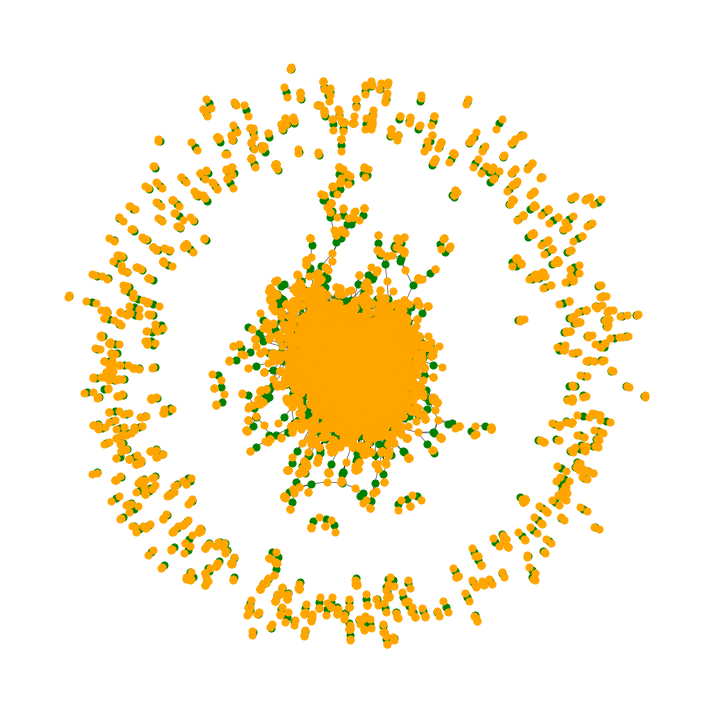

In [9]:
# Determine the nodes for each partition based on the 'bipartite' attribute
article_nodes = [n for n, d in B.nodes(data=True) if d['article']==1]
entity_nodes = [n for n, d in B.nodes(data=True) if d['article']==0]

# Create the bipartite layout
pos = nx.spring_layout(B, seed=34)

# Draw the graph
plt.figure(figsize=(10,10))

# Nodes
nx.draw_networkx_nodes(B, pos, nodelist=article_nodes, node_color='green', node_size=50)
nx.draw_networkx_nodes(B, pos, nodelist=entity_nodes, node_color='orange', node_size=50)

# Edges
nx.draw_networkx_edges(B, pos, width=1, alpha=0.5)  # added alpha for transparency

# If you want to show labels, uncomment the following line. Given the bipartite nature, it might clutter the visualization.
# nx.draw_networkx_labels(B, pos, font_size=12, font_family='sans-serif')

plt.axis('off')
plt.tight_layout()
plt.savefig('bipartite_graph.png', dpi=100)
plt.show()


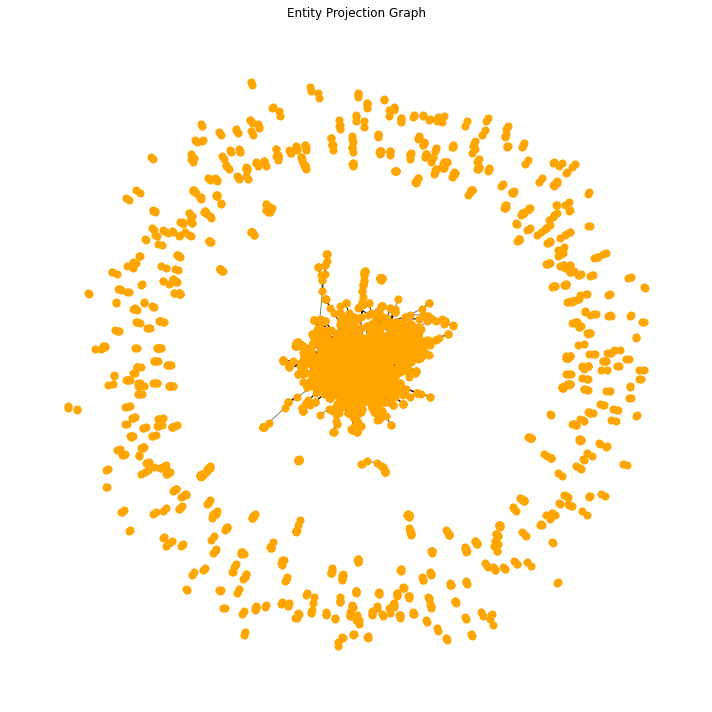

In [16]:
# 1. Create the entity projection
# Project the bipartite graph onto the entities nodes
entity_projection = nx.bipartite.weighted_projected_graph(B, entity_nodes)

# 2. Visualize the entity projection graph
# Use the spring layout for positioning
pos = nx.spring_layout(entity_projection, seed=34)

plt.figure(figsize=(10,10))

# Draw nodes and edges
nx.draw_networkx_nodes(entity_projection, pos, node_color='orange', node_size=50)
nx.draw_networkx_edges(entity_projection, pos, alpha=0.5)

# Labels can be added if desired, but with many nodes, it might be cluttered.
# If you want to show labels for specific important nodes or all nodes, you can uncomment the following line.
# nx.draw_networkx_labels(entity_projection, pos, font_size=10, font_family='sans-serif')

plt.title("Entity Projection Graph")
plt.axis('off')
plt.tight_layout()
plt.savefig('entity_projection_graph.png', dpi=100)
plt.show()

In [17]:
for u, v, data in entity_projection.edges(data=True):
    print(u, v, data['weight'])

 Allan Jacob 1
 pictwittercom/issxlTivHv 1
 Sara Duterte 1
 Solgen Heussaff 1
 https://tco/YgjYH51lBb   Jojo Clemente 1
 Miguel Enriquez 1
 Jeff Crisostomo 1
 Apollo Quiboloy 1
 glenn diaz 1
 Maria Esperanza 1
 miggy chavez 1
 Ramon Jimenez 1
 itinama jusko nakakadiri 1
 Prinz Magtulis 1
 leo 1
 Christina Garcia Frasco 1
 Christina Frasco 1
 https://tco/8cp1n7VGXZ pictwittercom/egxe4JHFh2 1
 Mon Jimenez 1
 Rodolfo Medrano 1
 Thea Tan 1
 https://tco/KnNLRYKvUl pictwittercom/13BpNva6wZ 1
 Enrico Patiga Villanueva 1
Charlie Ripley Sal Guatieri 1
Charlie Ripley Sarah House 1
Charlie Ripley Joe Biden 1
Charlie Ripley Sung Won Sohn 1
Charlie Ripley Mike Loewengart 1
Charlie Ripley Barry Gilbert 1
Charlie Ripley Jerome Powell 1
Tessie Sy Coson De Asis 1
Tessie Sy Coson Ramon Jocson 1
Tessie Sy Coson Joanne de Asis 1
Tessie Sy Coson Dennis Anthony Uy 1
Tessie Sy Coson Maria Grace 1
Tessie Sy Coson Nicanor R Austriaco 1
Tessie Sy Coson Eric Recto 1
Tessie Sy Coson Joey Concepcion III 1
Tessie S

Manuel Abecasis Nela Richardson 1
Manuel Abecasis Chris McKinney 1
Manuel Abecasis Jon Willis 1
Manuel Abecasis Raphael Bostic 1
Manuel Abecasis Jerome Powell 1
Manuel Abecasis Dave Gilbertson 1
Martin Gruenberg Andrew Bailey 1
Martin Gruenberg Mayra Rodriguez Valladares 1
Martin Gruenberg Mike Rounds 1
Martin Gruenberg Michael Purves 1
Martin Gruenberg Greg Becker 1
Martin Gruenberg Randal Quarles 1
Martin Gruenberg Steve Daines 1
Martin Gruenberg Jason Ware 1
Martin Gruenberg Mary Daly 1
Martin Gruenberg Danni Hewson 1
Martin Gruenberg John Kennedy 1
Martin Gruenberg Eric Compton 1
Martin Gruenberg Jeff Zients 1
Martin Gruenberg Michael Hsu 1
Martin Gruenberg Elizabeth Warren 3
Martin Gruenberg Tim Scott 1
Martin Gruenberg Nellie Liang 1
Martin Gruenberg Sheila Bair 1
Martin Gruenberg Garry Tan 1
Martin Gruenberg Greg Baer 1
Martin Gruenberg Jerome Powell 3
Martin Gruenberg Antony Blinken 1
Martin Gruenberg Greg Hertrich 1
Martin Gruenberg Janet Yellen 2
Martin Gruenberg Karl Schamot

Liu Kun Li Qiang 1
Liu Kun Li Keqiang 2
Liu Kun Zheng Shanjie 1
Liu Kun Ding Xuexiang 1
Liu Kun Li Shangfu 1
Liu Kun Xi Jinping 2
Liu Kun Zhu Hexin 1
Liu Kun Wang Wentao 1
Liu Kun Kang Yi 1
Liu Kun Mattie Bekink 1
Liu Kun Sun Fei 1
Liu Kun Zong Liang 1
Liu Kun Zhiwei Zhang 1
Liu Kun Yi Gang 1
Liu Kun Alfred Wu 1
Liu Kun Guo Tianyong 1
Jonathan Wilkinson Marcelo de Assis 1
Jonathan Wilkinson Rob Strong 1
Jonathan Wilkinson Jim Keating 1
Jonathan Wilkinson Ola Morten Aanestad 1
Jonathan Wilkinson Jean Francois Mercure 1
Jonathan Wilkinson Gretchen Fitzgerald 1
Jonathan Wilkinson Paul Goodfellow 1
Joanna Tyrowicz Erzsebet Kristofi 1
Joanna Tyrowicz Dan Bucsa 1
Joanna Tyrowicz Sandor Baja 1
Joanna Tyrowicz Marek Drimal 1
Joanna Tyrowicz Nicholas Farr 1
George Ball Sanders Morris Harris 1
George Ball James Bullard 1
George Ball Jim Veneau 1
George Ball Jerome Powell 1
George Ball Antony Blinken 1
Eduardo Francisco Anthony Ng 1
Diego Aponte Soren Toft 1
Diego Aponte Vincent Bollore 1
Diego A

Gullfaks A Aasta Hansteen 1
Gullfaks A Sleipner West 1
Gullfaks A Hildegunn Blindheim 1
Gullfaks A Maria Schumacher Walberg 1
Sarah Krissoff Duncan Levin 1
Sarah Krissoff Michael Jackson 1
Sarah Krissoff Stefan Cassella 1
Sarah Krissoff Vladimir Putin 1
Brian Dietz Jeremy Quek 1
Nestor Espenilla Jr Joseph Estrada 1
Nestor Espenilla Jr Felipe Medalla 1
Nestor Espenilla Jr Corazon Aquino 1
Nestor Espenilla Jr Treasurer Rosalia de Leon 1
Nestor Espenilla Jr Benjamin Diokno 1
Nestor Espenilla Jr Rodrigo Duterte 1
Nestor Espenilla Jr Ferdinand Marcos Jr 1
Nestor Espenilla Jr Coco Alcuaz 1
Nestor Espenilla Jr Arsenio Balisacan 1
Nestor Espenilla Jr Carlos Dominguez III 1
Gitanas Nauseda Christian Lindner 1
Gitanas Nauseda Ursula von der Leyen 1
Gitanas Nauseda Olaf Scholz 1
Gitanas Nauseda Janez Jansa 1
Gitanas Nauseda Elina Bardram 1
Gitanas Nauseda Fatih Birol 1
Gitanas Nauseda Mario Draghi 1
Gitanas Nauseda Vladimir Putin 2
Riya Vyas Pandu Sjahrir 1
Riya Vyas Joko Widodo 1
Riya Vyas Matt 

https://tco/KnNLRYKvUl pictwittercom/13BpNva6wZ https://tco/8cp1n7VGXZ pictwittercom/egxe4JHFh2 1
https://tco/KnNLRYKvUl pictwittercom/13BpNva6wZ Mon Jimenez 1
https://tco/KnNLRYKvUl pictwittercom/13BpNva6wZ Rodolfo Medrano 1
https://tco/KnNLRYKvUl pictwittercom/13BpNva6wZ Thea Tan 1
https://tco/KnNLRYKvUl pictwittercom/13BpNva6wZ Enrico Patiga Villanueva 1
Luis Mayorga Mark Sobel 1
Luis Mayorga Joe Biden 1
Luis Mayorga Mark Dowding 1
Luis Mayorga Donald Trump 1
Luis Mayorga Rishi Sunak 1
Luis Mayorga Bernie Sanders 1
Luis Mayorga Rick Meckler 1
Usec Panganiban Grace Poe 1
Usec Panganiban Inoue Jaena/Rappler 1
Usec Panganiban Jire Carreon/Rappler 1
Usec Panganiban Lilia Cruz 1
Usec Panganiban Leah Cruz ay 1
Usec Panganiban Risa Hontiveros 1
Usec Panganiban Ferdinand Marcos Jr 1
Usec Panganiban Gregorio San Diego 1
Usec Panganiban Arsenio Balisacan 1
Usec Panganiban Romel Calingasan 1
Usec Panganiban Angie de Silva/Rappler 1
Usec Panganiban Raul Montemayor 1
Usec Panganiban Leah Cruz 1


Alfredo Panlilio Lance Gokongwei 1
Alfredo Panlilio Joey Concepcion 1
Alfredo Panlilio Ramon Ang 1
Alfredo Panlilio Maria Rosario Vergeire 1
Alfredo Panlilio Josephine Gotianun Yap 1
Alfredo Panlilio Enrique Razon 1
Alfredo Panlilio Christopher Po 1
Alfredo Panlilio Nicanor Montoya 1
Alfredo Panlilio Mary Geraldine Polanco Onganon 1
Alfredo Panlilio alam kung underground 1
Alfredo Panlilio Century Tuna 1
Alfredo Panlilio Rene Limcaoco 1
Alfredo Panlilio Frederick Go 1
Alfredo Panlilio Benjamin Diokno 1
Alfredo Panlilio Bobby Claudio Sr 1
Alfredo Panlilio Hun Hun 1
Gianluca Pescaroli Avi Schnurr 1
Liz Coddington Barry McCarthy 1
Matthew Martin Selma Hepp 1
Matthew Martin Tim Quinlan 1
Matthew Martin Rubeela Farooqi 1
Matthew Martin Joanne Hsu 1
Matthew Martin Robert Frick 1
Matthew Martin Christopher Rupkey 1
Matthew Martin Conrad DeQuadros 1
Matthew Martin Jeffrey Roach 1
Jose Jalandoni Laguindingan Technopark 1
Louise Davidson Greg Busson 1
Louise Davidson Barbara Dischinger 1
Louise 

Zhang Ying David Kirton 1
Zhang Ying Steven Du 1
Zhang Ying Chang er dai 1
Jessica Amir Jonathan Mott 1
Jessica Amir Steve Englander 1
Jessica Amir Jamie Dimon 1
Jessica Amir Janet Yellen 1
Miguel Diaz Canel Omar Everleny 1
Miguel Diaz Canel Dalieny Ortega 1
Miguel Diaz Canel Pavel Vidal 1
Miguel Diaz Canel John Kavulich 1
Miguel Diaz Canel Oscar Fernandez 1
Miguel Diaz Canel Javeriana Cali 1
Todd Sohn Walter Todd 1
Todd Sohn Robby Greengold 1
Todd Sohn Alex Morris 1
Todd Sohn Peter Tuz 1
Zheng Shanjie Kang Yi 1
Zheng Shanjie Mattie Bekink 1
Zheng Shanjie Zhang Zhiwei 1
Zheng Shanjie Sun Fei 1
Zheng Shanjie Li Keqiang 1
Zheng Shanjie Yi Gang 1
Zheng Shanjie Ding Xuexiang 1
Zheng Shanjie Alfred Wu 1
Zheng Shanjie Li Shangfu 1
Zheng Shanjie Xi Jinping 1
Apollo Quiboloy Grace Poe 1
Apollo Quiboloy Allan Jacob 1
Apollo Quiboloy Karlo Nograles 1
Apollo Quiboloy Camille Villar 2
Apollo Quiboloy Sara Duterte 1
Apollo Quiboloy Francis Pangilinan 1
Apollo Quiboloy https://tco/YgjYH51lBb   Jojo 

Buboy Villar nyu kahit 1
Buboy Villar mo tapos hindi pa digital ready 1
Buboy Villar Felipe Gozon 1
Buboy Villar Vic Sotto 1
Buboy Villar Ella Blanca Lopez 1
Buboy Villar Manny V Pangilinan 1
Buboy Villar Santos City 1
Buboy Villar Pwede naman 1
Buboy Villar Isko Moreno 1
Buboy Villar Jeric Busa Polangco 1
Buboy Villar Mavy Legaspi 1
Buboy Villar Jehb Cosca Sarabillo 1
Buboy Villar hindi pa 1
Buboy Villar Betong Sumaya 1
Buboy Villar channelpa yan 1
Buboy Villar Comedian Joey de Leon 1
Wilson Bobier Anabelle Chua 1
Wilson Bobier Alexander Kibanoff 1
Wilson Bobier Mario Tamayo 1
Wilson Bobier Mary Rose Dela Paz 1
Kotaro Tsuru Hisashi Yamada 1
Kotaro Tsuru Fumio Kishida 1
Kotaro Tsuru Akira Nidaira 1
Kotaro Tsuru Tomoko Yoshino 1
Kotaro Tsuru Hiroya Nakai 1
Maria Mendiluce Silke Mooldijk 1
Maria Mendiluce Gilles Dufrasne 1
Maria Mendiluce Thomas Day 1
Steven Path Pierre Balsan 1
Steven Path Vanmunin Chhieng 1
Steven Path Chip Mong Land CEO 1
Steven Path Mong Reththy 1
Steven Path Henry L

De Castro Jose Raulito 1
De Castro Winnie Cordero 2
De Castro Jose Bartolome 1
De Castro Ging Reyes 1
De Castro Tony Velasquez 3
De Castro Francis "Kiko" 1
De Castro Cristina A Glindro 1
De Castro pictwittercom/PG7GRjK2dV   Karen Davila 1
De Castro Angelo Palmones 1
De Castro Doris Bigornia 2
De Castro DJ Toni Aquino 1
De Castro DJ Chacha 2
De Castro Ahwel Paz12:30 pm 1
De Castro Jonathan de Santos 1
De Castro Doris Bigornia7:30 1
De Castro Vic De Leon Lima 1
De Castro Adrian Ayalin 1
De Castro Cynthia M Te 1
De Castro Joyce Balancio 2
De Castro Peter Musngi 1
De Castro DosPorDos kasama 1
De Castro DJ Richards 1
De Castro Noli de Castro 2
De Castro Manny Villar 1
De Castro Andrew Julian 1
De Castro Felix Cesar L Zerrudo 1
De Castro Karen Davila 1
De Castro Alvin Elchico 3
De Castro hindi ko pa ho alam 1
De Castro Henry Omaga Diaz 1
De Castro Lia Marie N Te 1
De Castro David Oro 1
De Castro Anthony M Te 1
De Castro Gerry Baja 2
De Castro Chiz Escudero 1
De Castro alvin elchico 1
Schloss

Koya Miyamae Fumio Kishida 2
Koya Miyamae Hiroshi Nakaso 1
Koya Miyamae Daiju Aoki 1
Koya Miyamae Hideo Kumano 1
Koya Miyamae Shinzo Abe 1
Koya Miyamae Haruhiko Kuroda 1
Koya Miyamae Keiki Nambu 1
Andrey Kostin Roman Abramovich 1
Andrey Kostin Nikolai Tokarev 1
Andrey Kostin Alexei Miller 1
Andrey Kostin Oleg Deripaska 1
Andrey Kostin Vladimir Putin 1
Andrey Kostin Dmitri Lebedev 1
Damian Green Liz Truss 1
Damian Green Victoria Prentis 1
Damian Green Kwasi Kwarteng 1
Damian Green Mohamed El Erian 1
Damian Green Penny Mordaunt 1
Damian Green Boris Johnson 1
Damian Green Simon Clarke 1
Damian Green Suella Braverman 1
Sa EDSA busway Jaime Bautista 2
Sa EDSA busway Unang Balita 1
Sa EDSA busway Libreng Sakay 2
Sa EDSA busway ay dahil 1
Sa EDSA busway Ferdinand Marcos Jr 1
Maria Cantwell Joe Biden 1
Maria Cantwell Pete Buttigieg 1
Maria Cantwell Justin Kennedy 1
Maria Cantwell Ria Malhotra 1
Maria Cantwell Chris Torres 1
pero ako Alan Cayetano 1
pero ako Imee Marcos 1
pero ako Francis "Chiz

George Royeca Sabin Aboitiz 1
George Royeca Ginggay Hontiveros Malvar 1
George Royeca Henry Jr 1
George Royeca Nicanor S Montoya 1
George Royeca Irwin Lee 1
George Royeca Lance Gokongwei 1
George Royeca Joey Concepcion 1
George Royeca Ramon Ang 1
George Royeca Maria Rosario Vergeire 1
George Royeca Josephine Gotianun Yap 1
George Royeca Enrique Razon 1
George Royeca Christopher Po 1
George Royeca Nicanor Montoya 1
George Royeca Mary Geraldine Polanco Onganon 1
George Royeca Century Tuna 1
George Royeca Rene Limcaoco 1
George Royeca Frederick Go 1
George Royeca Benjamin Diokno 1
George Royeca Bobby Claudio Sr 1
George Royeca Hun Hun 1
Doug Parker Tammy Romo 1
Doug Parker Robin Hayes 1
Cielito Habito Florencio Abad 1
Cielito Habito Raul Fabella 1
Cielito Habito Chiz Escudero 1
Cielito Habito Filomeno Santa Ana III 1
Cielito Habito Diwa Guinigundo 1
Cielito Habito Felipe Medalla 1
Cielito Habito Benjamin Diokno 1
Cielito Habito Enrico Villanueva 1
Cielito Habito Dante Canlas 2
Cielito Hab

Imee Marcos Raymond Zorilla 1
Imee Marcos Trixie Cruz Angeles 1
Imee Marcos David Michael San Juan 2
Imee Marcos Arsenio Balisacan 2
Imee Marcos Cynthia Villar 1
Imee Marcos Dahil doon 1
Imee Marcos France Castro 1
Imee Marcos Corazon Aquino 1
Imee Marcos ang presidente 1
Imee Marcos tayo sa Maharlika Wealth Fund 1
Imee Marcos Ronald dela Rosa 1
Imee Marcos Enrico Villanueva 1
Imee Marcos Alfonso Cusi 1
Imee Marcos Carlos Dominguez III 2
Imee Marcos yun e Okay 1
Imee Marcos Joey Salceda 2
Imee Marcos ulit ako 1
Imee Marcos Neri Colmenares 1
Imee Marcos ho una 1
Imee Marcos Joel Villanueva 2
Imee Marcos Terry Ridon 1
Imee Marcos Bill No 1
Imee Marcos Merly Gallardo 1
Imee Marcos Francis Tolentino 1
Imee Marcos Najib Razak 2
Imee Marcos Bong Go 1
Imee Marcos Dennis Uy 1
Imee Marcos Grace Poe 1
Imee Marcos Mark Villar 1
Imee Marcos Ferdinand Marcos Jr 7
Imee Marcos Francis "Chiz 1
Imee Marcos Sherwin Gatchalian 1
Imee Marcos babahiin 'yung market 1
Imee Marcos Coco Levy 1
Imee Marcos Jame

Jonathan Heath Renzo Merino 1
Jonathan Heath Nikhil Sanghani 1
Chris Philp Stanley Druckenmiller 1
Chris Philp Liz Truss 1
Chris Philp Kwasi Kwarteng 1
Chris Philp Orla Garvey 1
Chris Philp Raphael Bostic 1
Chris Philp James Brundrett 1
Chris Philp Mario Draghi 1
Tarek Amer Hassan Abdalla 1
Tarek Amer Farouk Soussa 1
Tarek Amer Carla Slim 1
Matthew Shay Daniel Silver 1
Matthew Shay Gregory Daco 1
Matthew Shay Tim Quinlan 1
Matthew Shay Will Compernolle 1
Francisco Lim Eric Recalde 1
Francisco Lim Maria Ressa 1
Francisco Lim limitingFrancis lim 1
Zyra Orpiano Ronnie Ringor 1
Zyra Orpiano di ako titigil 1
Zyra Orpiano si ahente 1
James Bailey Andrew Opie 1
Mark Steel Martin Sorrell 1
Mark Steel John Rogers 1
Victor Ponsford Lindsay Owens 1
Anibor Kragha Aliko Dangote 1
Anibor Kragha Nana Akufo Addo 1
Anibor Kragha Senyo Hosi 1
Sobkasem Ngaemngam Ratchada Thanadirek 1
George Davis Janet Yellen 1
George Davis Kevin McCarthy 1
George Davis Giancarlo Giorgetti 1
Paul Ashworth Ryan Sweet 1
Pa

King Salman Khalid bin Salman 1
King Salman Prince Khalid bin Salman 1
King Salman Nawaf Saud al Sabah 1
King Salman Umer Karim 1
King Salman Haitham Al Ghais 1
King Salman Suhail al Mazrouei 1
King Salman Mohamed Arkab 1
King Salman John Kirby 1
Ajay Kumar Mishra Krishna Agarwal 1
Ajay Kumar Mishra Rahul Gandhi 1
Guillermo Ansay RJ Delos Santos 1
Guillermo Ansay Thelma Cerdena 1
Guillermo Ansay Delos Santos 1
Guillermo Ansay Gerardo Erguiza 1
Guillermo Ansay Sherwin Gatchalian 1
Guillermo Ansay Demujin Antiporda 1
Guillermo Ansay Roberto Uy 1
Guillermo Ansay Leonido Pulido 1
Guillermo Ansay Donato Marcos 1
Guillermo Ansay Alfonso Cusi 1
Guillermo Ansay Arthus Tenazas 1
Guillermo Ansay Dennis Uy 1
Viraj Patel Derek Halpenny 1
Viraj Patel Liz Truss 1
Viraj Patel Patrick Harker 1
Bernard Vincent Dy Meean Dy 1
Simon Rossi Keith Anderson 1
Simon Rossi Michael Lewis 1
Simon Rossi Chris O'Shea 1
Keren Torres Guillermo Camacaro 1
Keren Torres Maria Eugenia Duran 1
Keren Torres Hector Pineda 1

wala din Candice Iyog 1
Bill 6815 Stella Quimbo 1
Bill 6815 Juan Edgardo 1
Bill 6815 Sergio Ortiz Luis Jr 1
Bill 6815 Francis Quimba 1
Bill 6815 Bayanihan Cares 1
Bill 6815 Rolando Toledo 1
Bill 6815 OLIVENE Gozar 1
Bill 6815 Angelito Acupan 1
Bill 6815 Luna Cacanando 1
Bill 6815 Robert Bastillo 1
Leon Trotsky Hassan Malik 1
Leon Trotsky Chris Miller 1
Leon Trotsky Andrey Vavilov 1
Ben Ayers Sarah House 1
Ben Ayers Ryan Sweet 1
Ben Ayers Christopher Rupkey 1
Ben Ayers Conrad DeQuadros 1
Abheek Barua Radhika Rao 1
Arturo Bris Jean Dermine 1
Arturo Bris Jan Egbert Sturm 1
Arturo Bris Sergio Ermotti 1
Arturo Bris Marcel Rohner 1
Arturo Bris Stefan Legge 1
Arturo Bris Colm Kelleher 1
Arturo Bris Andre Helfenstein 1
Mark Rutte Roman Abramovich 1
Mark Rutte Emmanuel Macron 1
Mark Rutte Tayyip Erdogan 1
Mark Rutte Christine Lagarde 1
Mark Rutte Olaf Scholz 1
Mark Rutte Jerome Powell 1
Mark Rutte Lawrence Young 1
Mark Rutte Vladimir Putin 1
Halimbawa ako Joel Bolano 1
Halimbawa ako yung jeep 1

Robinsons Otis Robinsons Tagaytay 1
Robinsons Otis Robinsons Lipa 1
Robinsons Otis Robinsons Roxas 1
Alvin Bragg Alan Futerfas 1
Alvin Bragg Donald Trump 1
Alvin Bragg Letitia James 1
Alvin Bragg Alina Habba 1
Alvin Bragg Donald Trump Jr 1
Dickinson Wright Andreas Venditti 1
Dickinson Wright Daniel Bosshard 1
Dickinson Wright Luzerner Kantonalbank 1
Dickinson Wright Jacob Frenkel 1
George Congdon Joaquin Duato 1
George Congdon Rick Wise 1
Elizabeth Gaines Greg Busson 1
Elizabeth Gaines Barbara Dischinger 1
Elizabeth Gaines Kerin Collins 1
Elizabeth Gaines Katie Mehnert 1
Elizabeth Gaines Jakob Stausholm 1
Elizabeth Gaines Will Van De Pol 1
Elizabeth Gaines Madeleine King 1
hindi mo alam Yun po 'yung 1
hindi mo alam naibalik 'yan 1
hindi mo alam Gilda Maquilan 1
hindi mo alam Yun 'yung 1
Gero Neugebauer Kurt Vandaele 1
Gero Neugebauer Lane Windham 1
Gero Neugebauer Christian Smalls 1
Gero Neugebauer Sharan Burrow 1
Sean Snaith Brian Bethune 1
Sean Snaith Steven Blitz 1
Sean Snaith Donal

kamukha ko Buti kung 1
kamukha ko Manny Pangilinan 1
Mike Mullaney Joe Manimbo 1
Mike Mullaney David Bahnsen 1
Dhananath Fernando Thusitha Hadaragama 1
Dhananath Fernando Gotabaya Rajapaksa 1
Dhananath Fernando Mohammad Irfan 1
Scott Roe Ralph Lauren 1
Scott Roe Nicandro Durante 1
Scott Roe Roberto Eggs 1
Scott Roe Judith McKenna 1
Scott Roe Yves Briantais 1
Scott Roe Jane Nielsen 1
Scott Roe Vincent Warnery 1
Maria Zakharova Klaus Mueller 1
Maria Zakharova Dmitry Peskov 3
Maria Zakharova Konstantin Ernst 1
Maria Zakharova Jens Stoltenberg 1
Maria Zakharova Jens Schumann 1
Maria Zakharova Morten Bodskov 1
Maria Zakharova Aston Martin 1
Maria Zakharova Sergei Shoigu 1
Maria Zakharova Ursula von der Leyen 1
Maria Zakharova Liz Truss 1
Maria Zakharova Jeppe Kofod 1
Maria Zakharova Magdalena Andersson 1
Maria Zakharova Jonas Gahr Stoere 1
Maria Zakharova Josep Borrell 2
Maria Zakharova Claudio Descalzi 1
Maria Zakharova Rishi Sunak 1
Maria Zakharova Mikhail Fridman 1
Maria Zakharova Dmitry

Gilbert Santa Maria Vic Rodriguez 1
Gilbert Santa Maria Isko Moreno 1
Gilbert Santa Maria Ramon Ang 1
Gilbert Santa Maria the Ninoy Aquino International Airport 1
Gilbert Santa Maria Christopher Pastrana 1
Gilbert Santa Maria Lucio Tan 3
Gilbert Santa Maria Cesar Chavez 1
Gilbert Santa Maria Santa Maria 2
Gilbert Santa Maria Cheloy Garafil 1
Gilbert Santa Maria Ferdinand Marcos Jr 1
Karol Kierzkowski Mateusz Berger 1
Karol Kierzkowski Vladimir Putin 1
Chloe Gotsis Letitia James 1
Chloe Gotsis Maura Healey 1
Fabio Gamba Omar Alghabra 1
Fabio Gamba Dave Flowers 1
Zhang Kexing Christopher Beddor 1
Zhang Kexing Yin Peixin 1
Zhang Kexing Hong Hao 1
Zhang Kexing Gavekal Dragonomics 1
Zhang Kexing Chang Jiang Securities 1
Timothy Graf Michael Every 1
Alberta Pilliod Alva Pilliod 1
Alberta Pilliod Phillip Blank 1
Alberta Pilliod Edwin Hardeman 1
Kubanychbek Osmanaliev Oleksandr Kyryliuk 1
Kubanychbek Osmanaliev Samuel Smith 1
Kubanychbek Osmanaliev Vladimir Putin 1
Nicholas Farr Erzsebet Krist

Jim Chanos William C Martin 1
Jim Chanos Dennis Kelleher 1
Jim Chanos Ihor Dusaniwsky 1
Jim Chanos John Hempton 1
Jim Chanos David Sacks 1
Jim Chanos Barry Norris 1
Alfred Hansen Audun Ingvartsen 1
Alfred Hansen Aasta Hansteen 1
Alfred Hansen Sleipner West 1
Alfred Hansen Hildegunn Blindheim 1
Alfred Hansen Maria Schumacher Walberg 1
Vilius Sketrys Emre Atceken 1
Vilius Sketrys Linda Frohock 1
Vilius Sketrys Attila Knott 1
Vilius Sketrys Laszlo Puczko 1
Vilius Sketrys Keith Pollard 1
Vilius Sketrys Marton Monus 1
Vilius Sketrys Bob Martin 1
Rafael "Joel Rafael Consing 1
Rafael "Joel Joel Consing 1
Rafael "Joel Ferdinand Marcos Jr 1
Rafael "Joel Frederick Go 1
Rafael "Joel Enrique Razon 1
Rafael "Joel Consing Jr 1
Cyril Ramaphosa Leigh Driemel 1
Cyril Ramaphosa Frank Spencer 1
Cyril Ramaphosa Tabi Tabi 1
Cyril Ramaphosa Pierre Moureau 1
Cyril Ramaphosa Mark Evans 1
Cyril Ramaphosa Prince Mkhize 1
Cyril Ramaphosa Solly Silaule 1
Sofya Donets Adam Posen 1
Sofya Donets Tim Harcourt 1
Sofya

Najib Razak Paul Daza 1
Najib Razak Neri Colmenares 1
Najib Razak Terry Ridon 1
Najib Razak Sheikh Mansour 1
Najib Razak Marc Agnifilo 5
Najib Razak Sandro Marcos 2
Najib Razak Pangalawang Marcos 1
Najib Razak Benjamin Diokno 1
Tania Sibree Christian Brun 1
Tania Sibree Tara Joseph 1
Tania Sibree Robert Walters 1
Brad Erker Doug Goehring 1
Brad Erker Vance Ehmke 1
Brad Erker Romulo Lollato 1
Alex Lehmann Thomas Gottstein 1
Alex Lehmann Alfred Escher 1
Alex Lehmann Antonio Horta Osorio 1
Alex Lehmann Ulrich Koerner 1
Alex Lehmann Tidjane Thiam 1
Alex Lehmann Clariden Leu 1
Dimple Gosai Peter Harrison 1
Silvio Tavares Jerome Powell 1
Tanya Rabat Tan Imelda Romualdez Marcos Airport 1
Tanya Rabat Tan Nelson Dayanghirang 1
Guy Parmelin Boris Yeltsin 1
Guy Parmelin Andrey Melnichenko 1
Guy Parmelin Vladimir Yevtushenkov 1
Sergio Ortiz Luis Jr Stella Quimbo 1
Sergio Ortiz Luis Jr Juan Edgardo 1
Sergio Ortiz Luis Jr Francis Quimba 1
Sergio Ortiz Luis Jr Bayanihan Cares 1
Sergio Ortiz Luis Jr R

Christopher Po Ferdinand Marcos Jr 1
Christopher Po Ginggay Hontiveros Malvar 1
Christopher Po Henry Jr 1
Christopher Po Nicanor S Montoya 1
Christopher Po Joey Concepcion 1
Christopher Po Ramon Ang 1
Christopher Po Maria Rosario Vergeire 1
Christopher Po Josephine Gotianun Yap 1
Christopher Po Nicanor Montoya 1
Christopher Po Mary Geraldine Polanco Onganon 1
Christopher Po Century Tuna 1
Christopher Po Rene Limcaoco 1
Christopher Po Frederick Go 1
Christopher Po Benjamin Diokno 1
Christopher Po Hun Hun 1
Luhut Pandjaitan Bukit Asam 1
Luhut Pandjaitan Yeo Han koo 1
Luhut Pandjaitan Hendra Sinadia 1
Bob Jordan Tammy Romo 1
Ben Cohen Zinger et al v Ben & Jerry Homemade Inc et al 1
Ben Cohen Nelson Peltz 1
Ben Cohen Kimberly Yee 1
Ben Cohen Yair Lapid 1
Ben Cohen Omar Shakir 1
Ben Cohen Avi Zinger 2
Ben Cohen Thomas DiNapoli 1
Ben Cohen Alan Jope 1
Pierre et Vacances Mario Centeno 1
Pierre et Vacances Elizabeth Warren 1
Pierre et Vacances Christine Lagarde 1
Pierre et Vacances Philip Lane

Nina Jose Quiambao Elvin Laceda 1
Nina Jose Quiambao hindi kami 1
Nina Jose Quiambao De Jesus 1
Nina Jose Quiambao puwede dahil ibabayad 1
Nina Jose Quiambao Mark Quintos 1
Nina Jose Quiambao Kaya 'yung produkto 1
Nina Jose Quiambao Hindi ko alam kung 1
Nina Jose Quiambao hindi ko alam 1
Nina Jose Quiambao rin ako 1
Nina Jose Quiambao ganun din sa 1
Nina Jose Quiambao Hindi ko na meet 1
Joey Salceda Antonio Carpio 2
Joey Salceda Hindi puwedeng 1
Joey Salceda hindi ka 1
Joey Salceda Jose "Wick 1
Joey Salceda Mark Villar 2
Joey Salceda Trixie Cruz Angeles 1
Joey Salceda David Michael San Juan 2
Joey Salceda Ferdinand Marcos Jr 4
Joey Salceda Sherwin Gatchalian 1
Joey Salceda Coco Levy 2
Joey Salceda Migz Zubiri 1
Joey Salceda Ferdinand Marcos 1
Joey Salceda Yedda Romualdez 1
Joey Salceda France Castro 2
Joey Salceda ang presidente 1
Joey Salceda tayo sa Maharlika Wealth Fund 1
Joey Salceda po dapat 1
Joey Salceda Jude Acidre 1
Joey Salceda Alfonso Cusi 1
Joey Salceda Jose Calida 1
Joey S

ganun din sa Kaya 'yung produkto 1
ganun din sa Hindi ko alam kung 1
ganun din sa hindi ko alam 1
ganun din sa rin ako 1
ganun din sa Hindi ko na meet 1
Isabel Schnabel Boris Vujcic 1
Isabel Schnabel Pierre Olivier Gourinchas 1
Isabel Schnabel Monica Defend 1
Isabel Schnabel Sverre Alvik 1
Isabel Schnabel Jan von Gerich 1
Isabel Schnabel Carlo Franchini 1
Isabel Schnabel Kenneth Broux 1
Isabel Schnabel Craig Inches 1
Isabel Schnabel John Williams 1
Isabel Schnabel Jerome Powell 5
Isabel Schnabel Alan Gelder 1
Isabel Schnabel Erik Nielsen 1
Isabel Schnabel Klaas Knot 1
Isabel Schnabel Holger Schmieding 1
Isabel Schnabel Rodrigo Catril 1
Isabel Schnabel Robert Gentz 1
Isabel Schnabel Lykke Merklin 1
Isabel Schnabel Gabriel Makhlouf 1
Isabel Schnabel Martins Kazaks 1
Isabel Schnabel Thomas Costerg 1
Isabel Schnabel Pablo Hernandez de Cos 1
Robinsons Malabon Robinsons Fuente 1
Robinsons Malabon Robinsons Iligan 1
Robinsons Malabon Robinsons Santiago 1
Robinsons Malabon Robinsons Jaro 1
Rob

Ding Xuexiang Xi Jinping 1
Campbell Wilson Lars Wagner 1
Campbell Wilson Rishi Sunak 1
Yi Huiman Ting Lu 1
Yi Huiman Lei Meng 1
Yi Huiman Gavekal Dragonomics 1
kami komunista dahil sila mismo 1
kami komunista Hindi sila 1
kami komunista Mary Jane Cadella 1
kami komunista Kaya nila 1
kami komunista Sara Duterte 1
kami komunista drayber pa 1
kami komunista sa kalsada 1
Eva Herzog Hansjoerg Knecht 1
Eva Herzog Cedric Wermuth 1
Eva Herzog Karin Keller Sutter 1
Morten Frisch Felix Booth 1
Maria Sanchez Pedro Castillo 1
Maria Sanchez Elena Rodriguez 1
Syaizul Abdullah Syamil Zulkaffly Daniel Tan 1
ko dahil ni heeseung 1
ko dahil COMEBACK HEHE 1
ko dahil Di ko 1
ko dahil kayo mag 1
ko dahil bill ko 1
ko dahil hindi ako makajoin ng 1
ko dahil Scammer kayo 1
Eugene Shvidler Lady M yacht 1
Eugene Shvidler Alexei Mordashov 1
Eugene Shvidler Andrey Igorevich Melnichenko 1
Eugene Shvidler Dasha Zhukova 1
Eugene Shvidler Banning Russian 1
Eugene Shvidler Petr Aven 1
Eugene Shvidler Gennady Timchenko

Andrey Igorevich Melnichenko Gennady Timchenko 1
Andrey Igorevich Melnichenko Ray Harlem 1
Andrey Igorevich Melnichenko Philippe Starck 1
Andrey Igorevich Melnichenko Roman Abramovich 2
Andrey Igorevich Melnichenko Stavros Niarchos 1
Andrey Igorevich Melnichenko Vladimir Potanin 1
Andrey Igorevich Melnichenko Chris Bryant 1
Andrey Igorevich Melnichenko Alexander Abramov 1
Andrey Igorevich Melnichenko Mikhail Fridman 1
Andrey Igorevich Melnichenko Francis Bacon 1
Andrey Igorevich Melnichenko Alisher Usmanov 1
Klaus Miller Marianne Purushotham 1
Klaus Miller Narges Dorratoltaj 1
Klaus Miller Reinsurer Swiss Re 1
James Fry Thomas Mielke 1
James Fry Fadhil Hasan 1
James Fry Atul Chaturvedi 1
James Fry Rasheed JanMohd 1
Akiko Kojima Tomohiko Sano 1
Akiko Kojima Kasumi Mizoguchi 1
Nicholas Colas Prince Abdulaziz bin Salman 1
Nicholas Colas Janet Yellen 1
Nicholas Colas Kevin McCarthy 1
Nicholas Colas Volodymyr Zelenskiy 1
Nicholas Colas Chris Weston 1
Adrian Ayalin Johnson Manabat 1
Adrian A

Magdalena Andersson Jens Schumann 1
Magdalena Andersson Morten Bodskov 1
Magdalena Andersson Kristoffer Bottzauw 1
Magdalena Andersson Terje Aasland 1
Sean Padfield Kailash Krishnaswamy 1
Sean Padfield midday sun 1
Clara Street Tomas Street 1
Chito Maniago Benjo Basas 1
Jeff Gustavson Jennifer Granholm 1
Jeff Gustavson Fatih Birol 1
Jeff Gustavson Suhail al Mazrouei 1
Boris Vujcic Gabriel Makhlouf 1
Boris Vujcic Pablo Hernandez de Cos 1
Boris Vujcic Erik Nielsen 1
Boris Vujcic Klaas Knot 1
Judy Chan Hwee Bin Lim 3
Judy Chan Margo Brodie 1
Judy Chan Marc Agnifilo 3
Judy Chan Ng $35 million 1
Judy Chan Jho Low 1
Peiqian Liu Brian Coulton 1
Peiqian Liu Raymond Yeung 1
Egon Zehnder Elena Carletti 1
Egon Zehnder Stephanie Niven 1
Egon Zehnder Gertrude Tumpel Gugerell 1
Egon Zehnder Vincent Kaufmann 1
Egon Zehnder Simone Stebler 1
Egon Zehnder Gavin Rochussen 1
Egon Zehnder Andrea Orcel 1
Podujana Peramuna Gotabaya Rajapaksa 1
Haruhiko Kuroda Shinichi Uchida 3
Haruhiko Kuroda Thomas Jordan 1

Paolo Contis Isko Moreno Domagoso 1
Paolo Contis Madlang People 1
Paolo Contis Manny V Pangilinan 1
Paolo Contis Pwede naman 1
Paolo Contis Isko Moreno 1
Paolo Contis Jose Bartolome 1
Paolo Contis Tito Vic 1
Paolo Contis Jeric Busa Polangco 1
Paolo Contis Jehb Cosca Sarabillo 1
Paolo Contis hindi pa 1
Paolo Contis Barbie Forteza sa 1
Paolo Contis Unkabogable Superstar 1
Paolo Contis Manny Pacquiao 1
Garhi Yasin Shehbaz Sharif 1
Garhi Yasin Sain Bukash Husain 1
Garhi Yasin Dera Ismail Khan 1
Garhi Yasin Naveed Qamar 1
Garhi Yasin Malik Salim Awan 1
Suhail al Mazrouei Khalid bin Salman 1
Suhail al Mazrouei Jennifer Granholm 1
Suhail al Mazrouei Benchmark Brent 1
Suhail al Mazrouei Prince Abdulaziz bin Salman 1
Suhail al Mazrouei Nawaf Saud al Sabah 1
Suhail al Mazrouei Haitham Al Ghais 1
Suhail al Mazrouei Sultan Ahmed Al Jaber 1
Suhail al Mazrouei Amos Hochstein 1
Suhail al Mazrouei Fatih Birol 2
Suhail al Mazrouei Mohamed Arkab 1
Suhail al Mazrouei Prince Khalid bin Salman 1
Mike Doell

Antonio Cojuangco Ferdinand Marcos Jr 1
Antonio Cojuangco Imelda Marcos 1
Antonio Cojuangco Carmelo Arcilla 1
Antonio Cojuangco Manuel V Pangilinan 1
Antonio Cojuangco Okada Manila 3
Antonio Cojuangco Manuel Antonio Tamayo 1
Antonio Cojuangco Robert Galang 1
Antonio Cojuangco Carlos Dominguez III 1
Antonio Cojuangco Ramon Hernando 1
Antonio Cojuangco Alejandro Tengco 1
Antonio Cojuangco Antonio "Tonyboy 1
Antonio Cojuangco Lucio Tan 1
Antonio Cojuangco Mark Lopez 1
Antonio Cojuangco Jaime "Jimmy" Bautista 1
Antonio Cojuangco Michiaki Satate 1
Antonio Cojuangco Kazuo Okada 3
Antonio Cojuangco Jun Fujimoto 1
Antonio Cojuangco Crispin Remulla 1
Antonio Cojuangco Guido Zaballero 1
Antonio Cojuangco Dindo Espeleta III 1
Antonio Cojuangco Manny Pangilinan 2
Gavenkal Dragonomics Didi Chuxing 1
Laurent Thoumine Ewan Andrew 1
Laurent Thoumine Majid Al Futtaim 1
Laurent Thoumine Bruno Monteyne 1
Laurent Thoumine Kevin O'Marah 1
Nobuya Uranishi Hiromu Hatanaka 1
Nobuya Uranishi Kohei Takeuchi 1
L

Andy Cronin Eric Bernardini 1
Andy Cronin Lorenzo Marandola 1
Andy Cronin Steven Udvar Hazy 1
Pierre Poilievre Tiff Macklem 1
Pierre Poilievre Chrystia Freeland 1
Pierre Poilievre Carolyn Rogers 1
Pierre Poilievre Jean Chretien 1
Pierre Poilievre David Strva 1
Pierre Poilievre David Dodge 1
Pierre Poilievre Derek Holt 1
Pierre Poilievre John Crow 1
Tony Fernandes Pete Chareonwongsak 1
Dickie Wong Bao Fan 1
Dickie Wong Xi Jinping 1
Dickie Wong Guo Guangchang 1
ni hindi Sonny Angara 1
ni hindi Felipe Medalla 1
ni hindi Yung PAGCOR 2
ni hindi Rosalina De Leon 1
ni hindi Ferdinand Marcos Jr 1
ni hindi Migz Zubiri 1
ni hindi OK siya 2
ni hindi Win Gatchalian 1
ni hindi Benjamin Diokno 2
ni hindi Chiz Escudero 2
Pharrell Williams Stella McCartney 1
Pharrell Williams Rita Ora 1
Pharrell Williams Mario Ortelli 1
Pharrell Williams Jerry Lorenzo 1
Pharrell Williams Jenna Ortega 1
Pharrell Williams Bad Bunny 1
David Leechiu Mike Danganan 1
David Leechiu Ferdinand Marcos Jr 1
David Leechiu Maria M

Michael Wilson Keith Lerner 1
Michael Wilson Sam Stovall 1
Anthony Taberna Johnson Manabat 2
Anthony Taberna DZMM Teleradyo 1
Anthony Taberna Migs Bustos 1
Anthony Taberna Bernadette Sembrano 3
Anthony Taberna Jun Banaag 1
Anthony Taberna Danilo Arao 1
Anthony Taberna Dos Por Dos 1
Anthony Taberna Blas Gilbert Z Villaroman 1
Anthony Taberna Ferdinand Marcos Jr 1
Anthony Taberna Winnie Cordero 2
Anthony Taberna Jose Bartolome 1
Anthony Taberna Ging Reyes 1
Anthony Taberna Cristina A Glindro 1
Anthony Taberna Angelo Palmones 1
Anthony Taberna Doris Bigornia 2
Anthony Taberna DJ Toni Aquino 1
Anthony Taberna DJ Chacha 2
Anthony Taberna Amy Perez 1
Anthony Taberna Cynthia M Te 1
Anthony Taberna Joyce Balancio 1
Anthony Taberna DosPorDos kasama 1
Anthony Taberna Manny Villar 1
Anthony Taberna Andrew Julian 1
Anthony Taberna Felix Cesar L Zerrudo 1
Anthony Taberna Jeff Canoy 1
Anthony Taberna Henry Omaga Diaz 1
Anthony Taberna Gloria Macapagal Arroyo 1
Anthony Taberna Gerry Baja 2
Anthony Ta

Dmitry Polevoy Jack Sharples 1
Dmitry Polevoy Elvira Nabiullina 1
Mikal Watts Adam Pulaski 1
Mikal Watts Greg Gordon 1
Mikal Watts Erik Haas 1
Mikal Watts Michael Kaplan 2
Mikal Watts Jim Onder 1
Mikal Watts Linda Richenderfer 1
Miguel Lo Bianco Gustavo Giailevra 1
Miguel Lo Bianco Julio Calzada 1
Miguel Lo Bianco Andres Betiger 1
Miguel Lo Bianco Sante Fe 1
Tim Quinlan Sal Guatieri 1
Tim Quinlan Selma Hepp 2
Tim Quinlan Daniel Silver 1
Tim Quinlan Jeffrey Roach 1
Tim Quinlan Andrew Hollenhorst 1
Tim Quinlan Chris Low 1
Tim Quinlan Peter Essele 1
Robert Kuok Ferdinand E Marcos 1
Robert Kuok Ricardo Brito 1
Robert Kuok Yan sila 1
Robert Kuok Bree Jonson 1
Robert Kuok Cesar Ching 1
Robert Kuok Benigno "Ninoy 1
Robert Kuok Aquino Jr 1
Robert Kuok Lala Rimando 1
Robert Kuok Jose Rizal 1
Robert Kuok Roberto "Bobby" Ongpin 1
Robert Kuok John Gokongwei 1
Robert Kuok Gregorio "Greggy" Araneta 1
Robert Kuok Monica Arellano 1
Robert Kuok Cory Aquino 1
Robert Kuok Jose Miguel " 1
Robert Kuok Ed T

Jim McGovern Kevin McCarthy 1
Jim McGovern Matt Ward 1
Jim McGovern Bernie Sanders 1
Shila Vilker Paola Godoy 1
Shila Vilker Joaquin Rodriguez 1
Ruth Johanne Michal Piszko 1
Ruth Johanne Francesco Starace 1
Richard Hughes Paul Johnson 1
Richard Hughes Liz Truss 2
Richard Hughes Upbeat Hunt 1
Richard Hughes Rishi Sunak 2
Richard Hughes Ben Zaranko 1
Richard Hughes George Osborne 1
Jim Keating Marcelo de Assis 1
David Hendler David Solomon 1
Ernest Cu Dennis Anthony Uy 1
Ernest Cu Maria Grace 1
Ernest Cu Eric Recto 1
Ernest Cu Joey Concepcion III 1
Ernest Cu Arsenio Balisacan 1
Ernest Cu Manuel V Pangilinan 1
Ernest Cu Lucio Tan III 1
Ernest Cu Jose Campos 1
Ernest Cu Samuel Zacate 1
Ernest Cu Cherrylene Advincula 1
Ernest Cu Henry Rhoel Aguda 1
Ernest Cu Gie Polanco 1
Ernest Cu Alfredo Ayala 1
Ernest Cu Ferdinand  Marcos Jr 1
Ernest Cu Grace Poe 1
Ernest Cu Typhoon Odette 1
Ernest Cu Doris Ho 1
Ernest Cu Ferdinand Marcos Jr 1
Ernest Cu Henry Jr 1
Ernest Cu Nicanor S Montoya 1
Ernest Cu 

Jaime Zobel de Ayala Ferdinand Marcos Jr 1
Jaime Zobel de Ayala Mercedita Nolledo 1
Jaime Zobel de Ayala Manny Villar 1
Jaime Zobel de Ayala Jaime Augusto Zobel de Ayala 1
kasi naka reserve Cynthia Villar 1
kasi naka reserve Nicanor Briones 1
kasi naka reserve Alcala doon 1
kasi naka reserve Nueva Ejica 1
Moon Hong cheol Yoo Ha jin 1
Evan Wohlmann Paul Johnson 1
Evan Wohlmann Liz Truss 1
Evan Wohlmann Marcus Brookes 1
Boni Serrano AvenueE Rodriguez Jr Avenue Maria Della Strada Parish)Katipunan Avenue 1
Boni Serrano AvenueE Rodriguez Jr Avenue Kamuning Market)E Rodriguez Sr 1
Boni Serrano AvenueE Rodriguez Jr Avenue D Munoz StOld 1
Boni Serrano AvenueE Rodriguez Jr Avenue LuisTime 1
Nils Wilm Sanoke Viswanathan 1
Nils Wilm Jamie Dimon 1
Nils Wilm Achim Oelgarth 1
Roberta Metsola Josep Borrell 1
Roberta Metsola Boris Johnson 1
Roberta Metsola Jen Psaki 1
Roberta Metsola Justin Trudeau 1
Ignacio Conde Ruiz Boris Plazzi 1
Mezbaul Haque Faisal Khan 1
Larry Meyer Fred Smith 1
Larry Meyer Jer

Nicanor Montoya Jose Campos 1
Nicanor Montoya Samuel Zacate 1
Nicanor Montoya Cherrylene Advincula 1
Nicanor Montoya Henry Rhoel Aguda 1
Nicanor Montoya Gie Polanco 1
Nicanor Montoya Doris Ho 1
Nicanor Montoya Ferdinand Marcos Jr 1
Nicanor Montoya Henry Jr 1
Nicanor Montoya Nicanor S Montoya 1
Nicanor Montoya Joey Concepcion 1
Nicanor Montoya Ramon Ang 1
Nicanor Montoya Maria Rosario Vergeire 1
Nicanor Montoya Mary Geraldine Polanco Onganon 1
Nicanor Montoya Century Tuna 1
Nicanor Montoya Frederick Go 1
Nicanor Montoya Benjamin Diokno 1
Nicolas Goldberg Robert Buckley 1
Nicolas Goldberg Boris Johnson 1
Nicolas Goldberg Bruno Le Maire 1
Carlos Gimenez Jen Psaki 1
Tiphaine Demandolx Alexandre Bompard 1
Mike Beaulieu Nathaniel Chouinard 1
Mike Beaulieu Rachel Blais 1
Mike Beaulieu Margaret Nakashuk 1
Mike Beaulieu Kenny Bell 1
Richard Koegler Robert Habeck 1
Richard Koegler Erik Passow 1
Bernard Arnault Priti Adani 1
Bernard Arnault Sam Bankman Fried 1
Bernard Arnault Henry Sy Sr 1
Bernar

Yan sila Bree Jonson 1
Yan sila Cesar Ching 1
Yan sila Benigno "Ninoy 1
Yan sila Aquino Jr 1
Yan sila Jose Rizal 1
Yan sila Roberto "Bobby" Ongpin 1
Yan sila John Gokongwei 1
Yan sila Monica Arellano 1
Yan sila Cory Aquino 1
Yan sila Jose Miguel " 1
Yan sila Ed Tordesillas 1
Yan sila Gloria Macapagal Arroyo 1
Yan sila MarcosFlores 1
Yan sila Jin Jiang City 1
Cesar Ching Ferdinand E Marcos 1
Cesar Ching Ricardo Brito 1
Cesar Ching Bree Jonson 1
Cesar Ching Benigno "Ninoy 1
Cesar Ching Aquino Jr 1
Cesar Ching Jose Rizal 1
Cesar Ching Roberto "Bobby" Ongpin 1
Cesar Ching John Gokongwei 1
Cesar Ching Monica Arellano 1
Cesar Ching Cory Aquino 1
Cesar Ching Jose Miguel " 1
Cesar Ching Ed Tordesillas 1
Cesar Ching Gloria Macapagal Arroyo 1
Cesar Ching MarcosFlores 1
Cesar Ching Jin Jiang City 1
Jim Cain Jack Hollis 1
Scott Schulte Daniel Krieter 1
Valery Joy Brion Ferdinand Marcos Jr 1
Valery Joy Brion Carlos Dominguez III 1
Michael Mainelli Liz Truss 1
Nuria Alvarez Pedro Sanchez 1
Nuria Alv

Matsuda Kenichi Marcos Sr 1
Matsuda Kenichi Ferdinand Marcos Sr 1
Matsuda Kenichi Ferdinand Marcos Jr 1
Andy Crocker Hilder Demeterio 1
Andy Crocker Drag Den 1
Stop Putin Kateryna Moroz 1
Susan Ople Nagiel Banacia 1
Thomas Richter Anne Rigail 1
Robert Caruso Christina Aguilera Fragrances 1
Robert Caruso Charles Lachman 1
Robert Caruso Chris Mittleman 1
Alison Kirsch Rashida Tlaib 1
Joseph DePaolo Eric Howell 1
Joseph DePaolo Randal Quarles 1
Joseph DePaolo Greg Baer 1
sa kalsada dahil sila mismo 1
sa kalsada Hindi sila 1
sa kalsada Sara Duterte 1
sa kalsada drayber pa 1
Gerry Baja DZMM Teleradyo 1
Gerry Baja Bernadette Sembrano 2
Gerry Baja Jun Banaag 1
Gerry Baja Danilo Arao 1
Gerry Baja Blas Gilbert Z Villaroman 1
Gerry Baja Ferdinand Marcos Jr 1
Gerry Baja Winnie Cordero 1
Gerry Baja Cristina A Glindro 1
Gerry Baja Doris Bigornia 2
Gerry Baja Joyce Balancio 1
Gerry Baja Manny Villar 1
Gerry Baja Chiz Escudero 1
Gabriel Boric Mario Marcel 1
Leila de Lima Maria Ressa 1
Neil Denman Jue

glenn diaz miggy chavez 1
glenn diaz Prinz Magtulis 1
glenn diaz Rodolfo Medrano 1
Maxim Sosov Robert Reading 1
Maxim Sosov Volpe Koenig 1
Chris Peeters Ursula von der Leyen 1
Chris Peeters Ulrik Stridsbaek 1
ArcelorMittal Kryvyi Rih Mauro Longobardo 1
ArcelorMittal Kryvyi Rih MMK Illicha 1
Bill Russo Oliver Wyman 1
Vyacheslav Volodin Ursula von der Leyen 1
Vyacheslav Volodin James Waddell 1
Crispin Remulla Okada Manila 1
Crispin Remulla Dindo Espeleta III 1
Crispin Remulla Raphael Lotilla 1
Crispin Remulla Ferdinand Marcos Jr 1
Dindo Espeleta III Okada Manila 1
Jashan Kahlon Anil Bhardwaj 1
Jashan Kahlon Nagendra Yadav 1
Jashan Kahlon Anup Kumar Srivastava 1
Jeffrey Gundlach Daniel Ivascyn 1
Tina Fordham Chris Weafer 1
Tina Fordham Arne Petimezas 1
Hindi ba dapat GNPower Dinginin 1
Hindi ba dapat Avril de Torres 1
Sri Lankan rupees Peter Jayem Alan 1
Sri Lankan rupees Nallathambi Mahendran 1
Sri Lankan rupees Joseph Campbell 1
Vivian Cheung Donald Morris 1
Kim Forrest Andy Saperstein 

kasi binoto boto Hindi pala kuwan 1
kasi binoto boto pa ko 1
kasi binoto boto hindi rin pala 1
Trixie Cruz Angeles Ferdinand Marcos Jr 5
Trixie Cruz Angeles Vince Perez 1
Trixie Cruz Angeles Benjamin Diokno 1
Trixie Cruz Angeles Pedro Maniego Jr 1
Trixie Cruz Angeles Alfonso Cusi 1
Trixie Cruz Angeles Jose Calida 1
Doris Fu Zhilian Zhaopin 1
Doris Fu Xi Jinping 1
Nelson Peltz Jimmy Pitaro 1
Nelson Peltz Shakespeare Martineau 1
Nelson Peltz Bruno Monteyne 3
Nelson Peltz Kimberly Yee 1
Nelson Peltz Thomas DiNapoli 1
Juan Edgardo Angelito Acupan 1
Juan Edgardo Luna Cacanando 1
Annalena Baerbock Juergen Matthes 1
Annalena Baerbock Qin Gang 1
Annalena Baerbock Ursula Von der Leyen 1
Annalena Baerbock Gerhard Schroeder 1
Annalena Baerbock Hanno Kempermann 1
Vince Perez Alfonso Cusi 1
Vince Perez Pedro Maniego Jr 1
Vince Perez Ferdinand Marcos Jr 1
Richard Branson David Ryder 1
Jerome Powell Sal Guatieri 3
Jerome Powell Joe Manimbo 2
Jerome Powell Ellen Hazen 2
Jerome Powell Gita Gopinath 1
J

In [18]:
# Sort nodes by degree in descending order
sorted_degree = sorted(dict(entity_projection.degree()).items(), key=lambda item: item[1], reverse=True)

# Get the top 10 nodes and their degrees
top_10_degree = sorted_degree[:10]

# Convert to a pandas DataFrame
df_top_10 = pd.DataFrame(top_10_degree, columns=['Node', 'Degree'])

df_top_10

,Node,Degree
0,Joe Biden,582
1,Ferdinand Marcos Jr,529
2,Vladimir Putin,474
3,Rodrigo Duterte,311
4,Jerome Powell,302
5,Janet Yellen,251
6,Liz Truss,206
7,Xi Jinping,194
8,Donald Trump,171
9,Benjamin Diokno,168


In [19]:
# Calculate weighted degree (strength) for each node
weighted_degree = dict(entity_projection.degree(weight='weight'))

# Sort nodes by weighted degree in descending order
sorted_weighted_degree = sorted(weighted_degree.items(), key=lambda item: item[1], reverse=True)

# Get the top 10 nodes and their weighted degrees
top_10_weighted_degree = sorted_weighted_degree[:10]

# Convert to a pandas DataFrame
df_top_10_weighted = pd.DataFrame(top_10_weighted_degree, columns=['Node', 'Weighted Degree'])

df_top_10_weighted

,Node,Weighted Degree
0,Joe Biden,999
1,Ferdinand Marcos Jr,864
2,Vladimir Putin,764
3,Rodrigo Duterte,478
4,Jerome Powell,467
5,Janet Yellen,465
6,Liz Truss,330
7,Benjamin Diokno,265
8,Rishi Sunak,263
9,Donald Trump,246


In [20]:
# 2. Clustering Coefficient
clustering_coefficient = nx.clustering(entity_projection)
print(f"Average Clustering Coefficient: {nx.average_clustering(entity_projection)}")

# not interesting since all entities appearing in a single article will surely have 1

Average Clustering Coefficient: 0.813817278417306


In [21]:
clustering_coefficient_weighted = nx.clustering(entity_projection, weight='weight')
average_clustering_coefficient_weighted = sum(clustering_coefficient_weighted.values()) / len(entity_projection)
print(f"Average Weighted Clustering Coefficient: {average_clustering_coefficient_weighted}")

Average Weighted Clustering Coefficient: 0.016883838878198314


In [23]:
# Sort nodes by degree centrality in descending order
sorted_degree_centrality = sorted(nx.degree_centrality(entity_projection).items(), key=lambda item: item[1], reverse=True)

# Get the top 10 nodes and their degree centralities
top_10_degree_centrality = sorted_degree_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_degree_centrality = pd.DataFrame(top_10_degree_centrality, columns=['Node', 'Degree Centrality'])

df_top_10_degree_centrality

,Node,Degree Centrality
0,Joe Biden,0.084877
1,Ferdinand Marcos Jr,0.077147
2,Vladimir Putin,0.069126
3,Rodrigo Duterte,0.045355
4,Jerome Powell,0.044043
5,Janet Yellen,0.036605
6,Liz Truss,0.030042
7,Xi Jinping,0.028292
8,Donald Trump,0.024938
9,Benjamin Diokno,0.024501


In [25]:
def weighted_degree_centrality(G, weight='weight'):
    # Calculate the weighted degree (strength) for each node
    strength = dict(G.degree(weight=weight))
    
    # Normalize by the maximum possible strength in the network (n-1 where n is the number of nodes)
    return {node: strength_val / (len(G) - 1) for node, strength_val in strength.items()}

# Calculate weighted degree centrality for each node
weighted_degree_cent = weighted_degree_centrality(entity_projection, weight='weight')

# Sort nodes by weighted degree centrality in descending order
sorted_weighted_degree_cent = sorted(weighted_degree_cent.items(), key=lambda item: item[1], reverse=True)

# Get the top 10 nodes and their weighted degree centralities
top_10_weighted_degree_cent = sorted_weighted_degree_cent[:10]

# Convert to a pandas DataFrame
df_top_10_weighted_degree_centrality = pd.DataFrame(top_10_weighted_degree_cent, columns=['Node', 'Weighted Degree Centrality'])

df_top_10_weighted_degree_centrality

,Node,Weighted Degree Centrality
0,Joe Biden,0.145691
1,Ferdinand Marcos Jr,0.126003
2,Vladimir Putin,0.111419
3,Rodrigo Duterte,0.069710
4,Jerome Powell,0.068106
5,Janet Yellen,0.067814
6,Liz Truss,0.048126
7,Benjamin Diokno,0.038647
8,Rishi Sunak,0.038355
9,Donald Trump,0.035876


In [25]:
# Sort nodes by closeness centrality in descending order
sorted_closeness_centrality = sorted(
    nx.closeness_centrality(entity_projection).items(),
    key=lambda item: item[1],
    reverse=True
)

# Get the top 10 nodes and their closeness centralities
top_10_closeness_centrality = sorted_closeness_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_closeness = pd.DataFrame(top_10_closeness_centrality, columns=['Node', 'Closeness Centrality'])

df_top_10_closeness

,Node,Closeness Centrality
0,Joe Biden,0.331680
1,Vladimir Putin,0.296103
2,Donald Trump,0.294322
3,Xi Jinping,0.291003
4,Janet Yellen,0.285571
5,Kristalina Georgieva,0.279463
6,Jerome Powell,0.278704
7,Ferdinand Marcos Jr,0.276815
8,Rishi Sunak,0.275654
9,Ursula von der Leyen,0.273379


In [84]:
# Calculate the weighted closeness centrality for each node
# The distance parameter is set to the 'weight' attribute to account for edge weights
weighted_closeness_cent = nx.closeness_centrality(entity_projection, distance='weight')

# Sort nodes by weighted closeness centrality in descending order
sorted_weighted_closeness_cent = sorted(weighted_closeness_cent.items(), key=lambda item: item[1], reverse=True)

# Get the top 10 nodes and their weighted closeness centralities
top_10_weighted_closeness_cent = sorted_weighted_closeness_cent[:10]

# Convert to a pandas DataFrame
df_top_10_weighted_closeness_centrality = pd.DataFrame(top_10_weighted_closeness_cent, columns=['Node', 'Weighted Closeness Centrality'])

df_top_10_weighted_closeness_centrality

,Node,Weighted Closeness Centrality
0,Joe Biden,0.290301
1,Donald Trump,0.260562
2,Rishi Sunak,0.255793
3,Ben van Beurden,0.253116
4,Ferdinand Marcos Jr,0.250493
5,Janet Yellen,0.249987
6,Liz Truss,0.249055
7,Rodrigo Duterte,0.247881
8,Jamie Dimon,0.247720
9,Xi Jinping,0.247109


In [26]:
# Sort nodes by betweenness centrality in descending order
sorted_betweenness_centrality = sorted(
    nx.betweenness_centrality(entity_projection).items(),
    key=lambda item: item[1],
    reverse=True)

# Get the top 10 nodes and their betweenness centralities
top_10_betweenness_centrality = sorted_betweenness_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_betweenness = pd.DataFrame(top_10_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

df_top_10_betweenness

,Node,Betweenness Centrality
0,Joe Biden,0.226469
1,Ferdinand Marcos Jr,0.129743
2,Vladimir Putin,0.098049
3,Xi Jinping,0.063792
4,Donald Trump,0.058784
5,Rodrigo Duterte,0.057871
6,Jerome Powell,0.050466
7,Janet Yellen,0.037458
8,Rishi Sunak,0.024459
9,Elon Musk,0.022282


In [27]:
# 6. Density
density = nx.density(entity_projection)
print(f"Density: {density}")

Density: 0.0013365144290608125


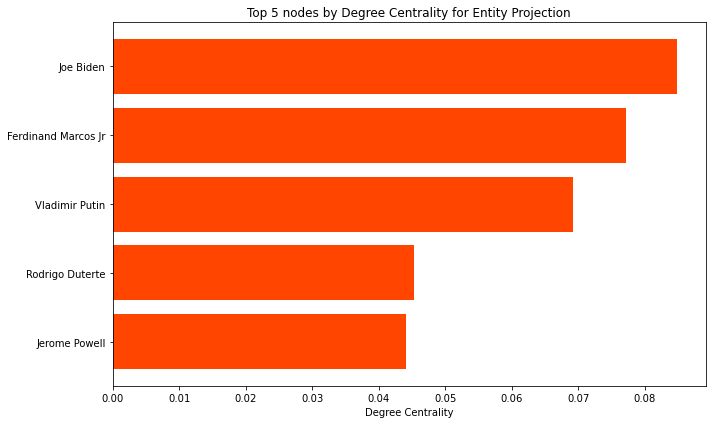

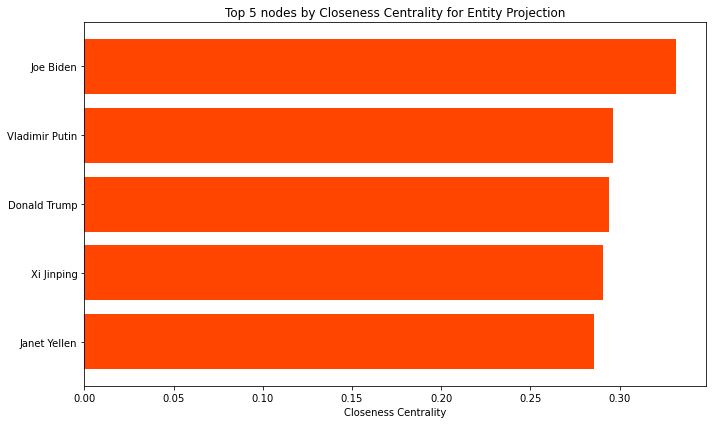

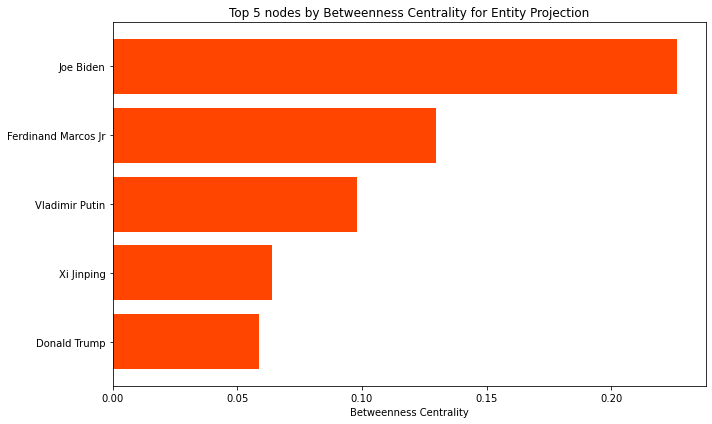

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

def plot_top_centrality(df, centrality_label, graph_title):
    """
    Function to plot top centrality measures in a horizontal bar chart
    """
    nodes = df['Node'].tolist()
    centrality_values = df[centrality_label].tolist()
    
    plt.figure(figsize=(10, 6))
    plt.barh(nodes, centrality_values, color='orangered')
    plt.xlabel(centrality_label)
    plt.title(f"Top 5 nodes by {centrality_label} for {graph_title}")
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest value at the top
    plt.tight_layout()
    plt.savefig(f"{centrality_label} for {graph_title}.png")
    plt.show()

# Assuming `entity_projection` is your graph of interest
graph_title = "Entity Projection"  # Replace with a suitable title

# Degree Centrality
sorted_degree_centrality = sorted(nx.degree_centrality(entity_projection).items(), key=lambda item: item[1], reverse=True)
df_top_5_degree_centrality = pd.DataFrame(sorted_degree_centrality[:5], columns=['Node', 'Degree Centrality'])
plot_top_centrality(df_top_5_degree_centrality, 'Degree Centrality', graph_title)

# Closeness Centrality
sorted_closeness_centrality = sorted(nx.closeness_centrality(entity_projection).items(), key=lambda item: item[1], reverse=True)
df_top_5_closeness = pd.DataFrame(sorted_closeness_centrality[:5], columns=['Node', 'Closeness Centrality'])
plot_top_centrality(df_top_5_closeness, 'Closeness Centrality', graph_title)

# Betweenness Centrality
sorted_betweenness_centrality = sorted(nx.betweenness_centrality(entity_projection).items(), key=lambda item: item[1], reverse=True)
df_top_5_betweenness = pd.DataFrame(sorted_betweenness_centrality[:5], columns=['Node', 'Betweenness Centrality'])
plot_top_centrality(df_top_5_betweenness, 'Betweenness Centrality', graph_title)


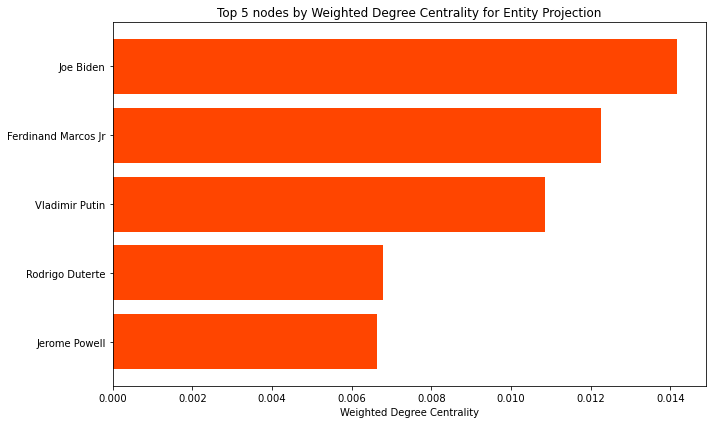

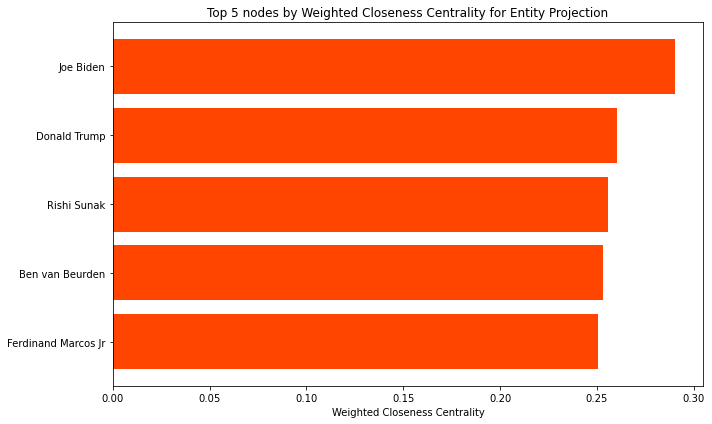

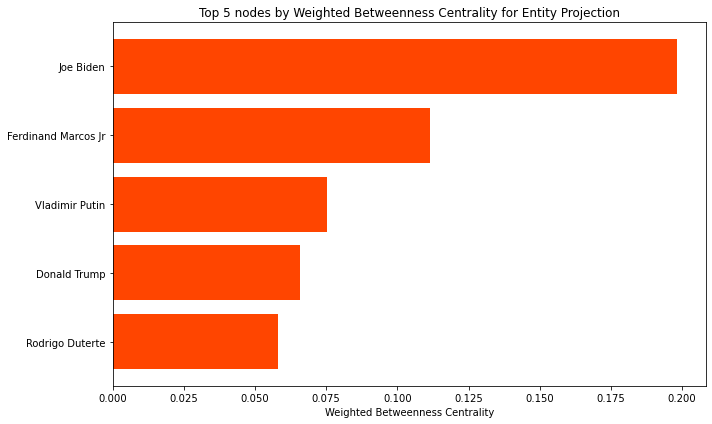

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

def plot_top_centrality(df, centrality_label, graph_title):
    """
    Function to plot top centrality measures in a horizontal bar chart
    """
    nodes = df['Node'].tolist()
    centrality_values = df[centrality_label].tolist()
    
    plt.figure(figsize=(10, 6))
    plt.barh(nodes, centrality_values, color='orangered')
    plt.xlabel(centrality_label)
    plt.title(f"Top 5 nodes by {centrality_label} for {graph_title}")
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest value at the top
    plt.tight_layout()
    plt.savefig(f"{centrality_label} for {graph_title}.png")
    plt.show()

# Assuming `entity_projection` is your graph of interest
graph_title = "Entity Projection"  # Replace with a suitable title

# Weighted Degree Centrality
total_weights = sum(dict(entity_projection.degree(weight='weight')).values())
weighted_degree_centrality = {node: deg/total_weights for node, deg in dict(entity_projection.degree(weight='weight')).items()}
sorted_degree_centrality = sorted(weighted_degree_centrality.items(), key=lambda item: item[1], reverse=True)
df_top_5_degree_centrality = pd.DataFrame(sorted_degree_centrality[:5], columns=['Node', 'Weighted Degree Centrality'])
plot_top_centrality(df_top_5_degree_centrality, 'Weighted Degree Centrality', graph_title)

# Weighted Closeness Centrality
sorted_closeness_centrality = sorted(nx.closeness_centrality(entity_projection, distance='weight').items(), key=lambda item: item[1], reverse=True)
df_top_5_closeness = pd.DataFrame(sorted_closeness_centrality[:5], columns=['Node', 'Weighted Closeness Centrality'])
plot_top_centrality(df_top_5_closeness, 'Weighted Closeness Centrality', graph_title)

# Weighted Betweenness Centrality
sorted_betweenness_centrality = sorted(nx.betweenness_centrality(entity_projection, weight='weight').items(), key=lambda item: item[1], reverse=True)
df_top_5_betweenness = pd.DataFrame(sorted_betweenness_centrality[:5], columns=['Node', 'Weighted Betweenness Centrality'])
plot_top_centrality(df_top_5_betweenness, 'Weighted Betweenness Centrality', graph_title)


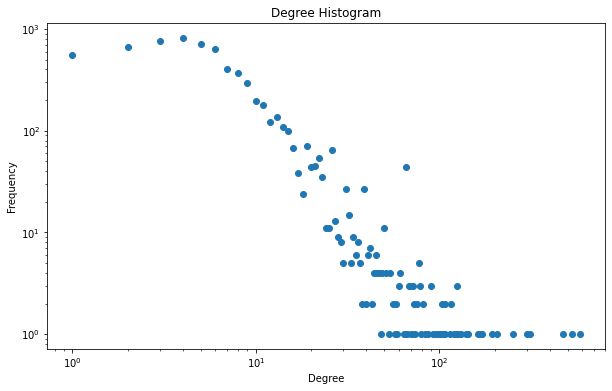

Average Clustering Coefficient: 0.8138172784173061
The entity_projection graph is not connected. Cannot compute average shortest path length.
Density: 0.0013365144290608125
Average Degree Centrality: 0.0013365144290608492
Average Closeness Centrality: 0.1506887179057598
Average Betweenness Centrality: 0.0002849247317061427
Average Eigenvector Centrality: 0.001777728370563071


In [33]:
# 1. Degree Distribution
degree_sequence = sorted([d for n, d in entity_projection.degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

plt.figure(figsize=(10, 6))
plt.loglog(deg, cnt, 'o')
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# 2. Clustering Coefficient
avg_clustering = nx.average_clustering(entity_projection)
print(f"Average Clustering Coefficient: {avg_clustering}")

# 3. Average Shortest Path Length (this can be computationally intensive for large networks)
# First, check if the graph is connected
if nx.is_connected(entity_projection):
    avg_path_length = nx.average_shortest_path_length(entity_projection)
    print(f"Average Shortest Path Length: {avg_path_length}")
else:
    print("The entity_projection graph is not connected. Cannot compute average shortest path length.")
    
# 4. Density
density = nx.density(entity_projection)
print(f"Density: {density}")

# 5. Degree Centrality
degree_centrality = nx.degree_centrality(entity_projection)
avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
print(f"Average Degree Centrality: {avg_degree_centrality}")

# 6.Closeness Centrality
closeness_centrality = nx.closeness_centrality(entity_projection)
avg_closeness_centrality = sum(closeness_centrality.values()) / len(closeness_centrality)
print(f"Average Closeness Centrality: {avg_closeness_centrality}")

# 7. Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(entity_projection)
avg_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)
print(f"Average Betweenness Centrality: {avg_betweenness_centrality}")

# 8. Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(entity_projection, max_iter=1000)
avg_eigenvector_centrality = sum(eigenvector_centrality.values()) / len(eigenvector_centrality)
print(f"Average Eigenvector Centrality: {avg_eigenvector_centrality}")


## Articles linked by Similar Entities

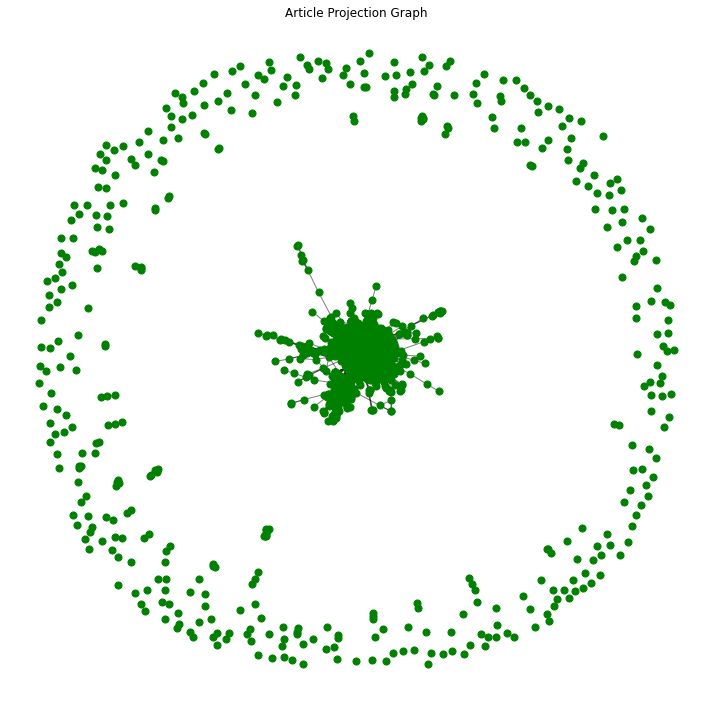

In [80]:
# 1. Create the article projection
# Project the bipartite graph onto the article nodes
article_projection = nx.bipartite.weighted_projected_graph(B, article_nodes)

# 2. Visualize the article projection graph
# Use the spring layout for positioning
pos = nx.spring_layout(article_projection, seed=34)

plt.figure(figsize=(10,10))

# Draw nodes and edges
nx.draw_networkx_nodes(article_projection, pos, node_color='green', node_size=50)
nx.draw_networkx_edges(article_projection, pos, alpha=0.5)

# Labels can be added if desired, but with many nodes, it might be cluttered.
# If you want to show labels for specific important nodes or all nodes, you can uncomment the following line.
# nx.draw_networkx_labels(article_projection, pos, font_size=10, font_family='sans-serif')

plt.title("Article Projection Graph")
plt.axis('off')
plt.tight_layout()
plt.savefig('article_projection_graph.png', dpi=100)
plt.show()

In [15]:
df['article_title'] = df['link'].str.split('/').apply(lambda x: x[-2])

In [16]:
# Sort nodes by degree in descending order
sorted_degree = sorted(
    dict(article_projection.degree()).items(),
    key=lambda item: item[1],
    reverse=True
)

# Get the top 10 nodes and their degrees
top_10_degree = sorted_degree[:10]

# Convert to a pandas DataFrame
df_top_10 = pd.DataFrame(top_10_degree,
                         columns=['Node', 'Degree'])

df_top_10['titles'] = df.set_index("id")['article_title'].loc[
    df_top_10.Node
].tolist()

df_top_10

,Node,Degree,titles
0,1750778,594,united-states-federal-reserve-white-house-slow...
1,1563360,545,updates-global-stock-markets-oil-prices-januar...
2,1646105,524,united-states-sanctions-russia-sberbank-putin-...
3,2276457,510,artificial-intelligence-race-canva-draws-line-...
4,1596589,482,momentum-grows-ban-russia-swift-payment-system...
5,1631758,469,china-sinopec-pauses-russia-projects-wary-sanc...
6,1631719,468,united-states-european-union-liquefied-natural...
7,1600144,466,china-boosts-oil-reserves-ignoring-united-stat...
8,2123714,466,russia-says-nord-stream-likely-hit-state-backe...
9,1597716,465,united-states-allies-target-russia-swift-ban-c...


In [17]:
# 2. Clustering Coefficient
clustering_coefficient = nx.clustering(article_projection)
print(f"Average Clustering Coefficient: {nx.average_clustering(article_projection)}")

# not interesting since all entities appearing in a single article will surely have 1

Average Clustering Coefficient: 0.6367534381915688


In [18]:
# Sort nodes by degree centrality in descending order
sorted_degree_centrality = sorted(
    nx.degree_centrality(article_projection).items(),
    key=lambda item: item[1],
    reverse=True
)

# Get the top 10 nodes and their degree centralities
top_10_degree_centrality = sorted_degree_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_degree_centrality = pd.DataFrame(top_10_degree_centrality, columns=['Node', 'Degree Centrality'])

df_top_10_degree_centrality['titles'] = df.set_index("id")['article_title'].loc[
    df_top_10_degree_centrality.Node
].tolist()

df_top_10_degree_centrality

,Node,Degree Centrality,titles
0,1750778,0.206969,united-states-federal-reserve-white-house-slow...
1,1563360,0.189895,updates-global-stock-markets-oil-prices-januar...
2,1646105,0.182578,united-states-sanctions-russia-sberbank-putin-...
3,2276457,0.177700,artificial-intelligence-race-canva-draws-line-...
4,1596589,0.167944,momentum-grows-ban-russia-swift-payment-system...
5,1631758,0.163415,china-sinopec-pauses-russia-projects-wary-sanc...
6,1631719,0.163066,united-states-european-union-liquefied-natural...
7,1600144,0.162369,china-boosts-oil-reserves-ignoring-united-stat...
8,2123714,0.162369,russia-says-nord-stream-likely-hit-state-backe...
9,1597716,0.162021,united-states-allies-target-russia-swift-ban-c...


In [19]:
# Sort nodes by closeness centrality in descending order
sorted_closeness_centrality = sorted(
    nx.closeness_centrality(article_projection).items(),
    key=lambda item: item[1],
    reverse=True
)

# Get the top 10 nodes and their closeness centralities
top_10_closeness_centrality = sorted_closeness_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_closeness = pd.DataFrame(top_10_closeness_centrality, columns=['Node', 'Closeness Centrality'])

df_top_10_closeness['titles'] = df.set_index("id")['article_title'].loc[
    df_top_10_closeness.Node
].tolist()

df_top_10_closeness

,Node,Closeness Centrality,titles
0,2276457,0.405815,artificial-intelligence-race-canva-draws-line-...
1,1750778,0.405179,united-states-federal-reserve-white-house-slow...
2,1563360,0.399002,updates-global-stock-markets-oil-prices-januar...
3,1646105,0.397851,united-states-sanctions-russia-sberbank-putin-...
4,1597716,0.393459,united-states-allies-target-russia-swift-ban-c...
5,1596589,0.393235,momentum-grows-ban-russia-swift-payment-system...
6,1631758,0.392191,china-sinopec-pauses-russia-projects-wary-sanc...
7,1600144,0.391745,china-boosts-oil-reserves-ignoring-united-stat...
8,1861260,0.391522,saudi-arabia-walks-oil-policy-tightrope-betwee...
9,1631719,0.391374,united-states-european-union-liquefied-natural...


In [20]:
# Sort nodes by betweenness centrality in descending order
sorted_betweenness_centrality = sorted(
    nx.betweenness_centrality(article_projection).items(),
    key=lambda item: item[1],
    reverse=True)

# Get the top 10 nodes and their betweenness centralities
top_10_betweenness_centrality = sorted_betweenness_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_betweenness = pd.DataFrame(top_10_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

df_top_10_betweenness['titles'] = df.set_index("id")['article_title'].loc[
    df_top_10_betweenness.Node
].tolist()

df_top_10_betweenness

,Node,Betweenness Centrality,titles
0,2276457,0.169926,artificial-intelligence-race-canva-draws-line-...
1,2226280,0.017709,air-india-seals-record-order-airbus-boeing-jet...
2,1583387,0.016550,unilever-expects-new-ben-jerrys-arrangement-is...
3,1822661,0.016293,build-build-build-mapping-duterte-administrati...
4,2195285,0.016105,is-it-time-philippines-air-traffic-control-be-...
5,2134804,0.010633,international-monetary-fund-message-britain-of...
6,1647197,0.010304,easy-russia-sanctions-exhausted-united-states-...
7,2202488,0.009954,explainer-davos-2023-world-economic-forum
8,2136703,0.009875,britain-chancellor-exchequer-jeremy-hunt-vows-...
9,2291023,0.008828,united-states-california-regulators-seize-firs...


In [21]:
# 6. Density
density = nx.density(article_projection)
print(f"Density: {density}")

Density: 0.025947568924860765


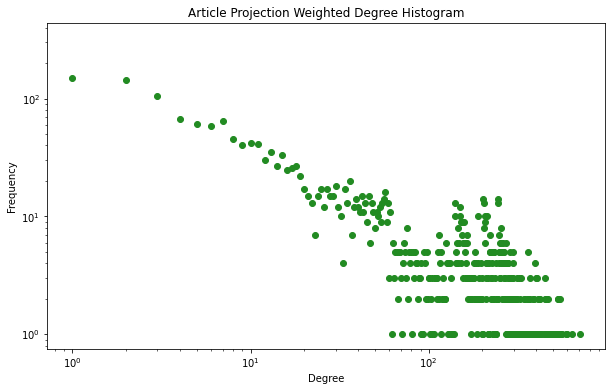

Weighted Average Clustering Coefficient: 0.05565409461143559
The article_projection graph is not connected. Cannot compute average shortest path length.
Density: 0.025947568924860765
Weighted Average Degree Centrality: 0.02594756892486076
Weighted Average Closeness Centrality: 0.23032488689070446
Weighted Average Betweenness Centrality: 0.0005623857450355932
Average Eigenvector Centrality: 0.007960050163795553


In [83]:
import collections
import matplotlib.pyplot as plt
import networkx as nx

# Assuming the article_projection is already defined elsewhere in your code
# For demonstration, I'm simply renaming entity_projection to article_projection

# 1. Weighted Degree Distribution
degree_sequence = sorted([d for n, d in article_projection.degree(weight='weight')], reverse=True)
degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

plt.figure(figsize=(10, 6))
plt.loglog(deg, cnt, 'o', color='forestgreen')  # Set color to forest green
plt.title("Article Projection Weighted Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency")

plt.savefig("weighted_article_degree_histogram.png", dpi=200)

plt.show()

# 2. Clustering Coefficient (weighted)
avg_clustering = nx.average_clustering(article_projection, weight='weight')
print(f"Weighted Average Clustering Coefficient: {avg_clustering}")

# 3. Average Shortest Path Length (weighted)
if nx.is_connected(article_projection):
    avg_path_length = nx.average_shortest_path_length(article_projection, weight='weight')
    print(f"Weighted Average Shortest Path Length: {avg_path_length}")
else:
    print("The article_projection graph is not connected. Cannot compute average shortest path length.")
    
# 4. Density
density = nx.density(article_projection)
print(f"Density: {density}")

# 5. Weighted Degree Centrality
degree_centrality = nx.degree_centrality(article_projection)
avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
print(f"Weighted Average Degree Centrality: {avg_degree_centrality}")

# 6. Closeness Centrality (weighted)
closeness_centrality = nx.closeness_centrality(article_projection, distance='weight')  # Note the distance parameter
avg_closeness_centrality = sum(closeness_centrality.values()) / len(closeness_centrality)
print(f"Weighted Average Closeness Centrality: {avg_closeness_centrality}")

# 7. Betweenness Centrality (weighted)
betweenness_centrality = nx.betweenness_centrality(article_projection, weight='weight')
avg_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)
print(f"Weighted Average Betweenness Centrality: {avg_betweenness_centrality}")

# 8. Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(article_projection, max_iter=1000)
avg_eigenvector_centrality = sum(eigenvector_centrality.values()) / len(eigenvector_centrality)
print(f"Average Eigenvector Centrality: {avg_eigenvector_centrality}")

## Temporal Analysis

In [7]:
def rolling_window_analysis(df, p):
    # Convert the 'date' column to datetime if it's not
    df['date'] = pd.to_datetime(df['date'])
    
    start_date = df['date'].min()
    end_date = df['date'].max()
    current_date = start_date
    
    results = {}
    
    while current_date <= end_date:
        # Filter dataframe for the current week
        week_df = df[(df['date'] >= current_date) & (df['date'] < current_date + timedelta(7))]
        
        # Create the bipartite graph
        B = nx.Graph()
        B.add_nodes_from(week_df['id'], bipartite=0)
        entities = [entity for sublist in week_df['unique_entities'] for entity in eval(sublist)]
        B.add_nodes_from(set(entities), bipartite=1)
        for _, row in week_df.iterrows():
            for entity in eval(row['unique_entities']):
                B.add_edge(row['id'], entity)
        
        # Project the bipartite graph
        entity_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}
        entity_projection = nx.bipartite.projected_graph(B, entity_nodes)
        
        # Calculate the degree
        degree_dict = dict(entity_projection.degree())
        for entity, degree in degree_dict.items():
            if entity not in results:
                results[entity] = []
            results[entity].append((current_date, degree))
        
        # Move to the next day
        current_date += timedelta(1)

    # Fill in missing dates with 0
    all_dates = pd.date_range(start_date, end_date)
    for entity in results:
        existing_dates = {date for date, _ in results[entity]}
        missing_dates = set(all_dates) - existing_dates
        for missing_date in missing_dates:
            results[entity].append((missing_date, 0))
        results[entity].sort()  # sort by date after filling missing values

    # Sort entities by their maximum degree achieved in any week
    max_degree_entities = sorted(results, key=lambda x: max([degree for _, degree in results[x]]), reverse=True)
    
    # Consider only the top p entities
    top_p_entities = max_degree_entities[:p]
    
    # Plotting
    plt.figure(figsize=(15, 10))
    for entity in top_p_entities:
        values = results[entity]
        dates, degrees = zip(*values)
        plt.plot(dates, degrees, '-', label=entity)
    
    plt.ylabel("Degree")
    plt.xlabel("Date")
    plt.title(f"Top {p} entities' degree progression over time")
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    plt.tight_layout()
    plt.show()


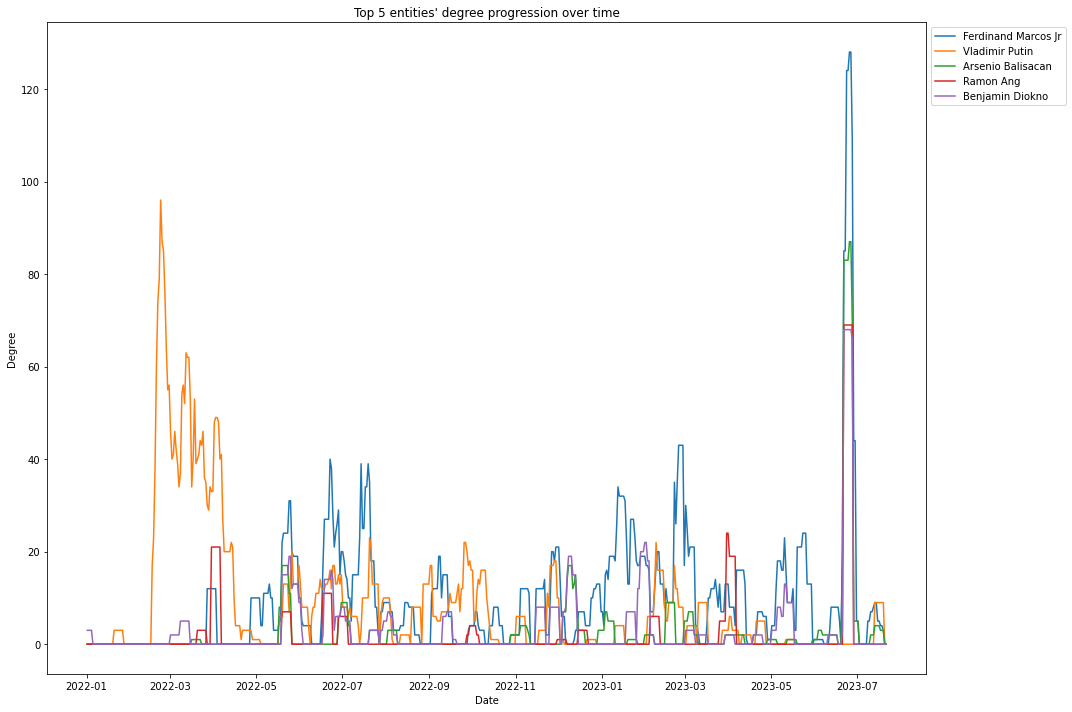

In [8]:
# Usage
rolling_window_analysis(df, 5)

In [26]:
def weighted_rolling_window_analysis(df, p):
    # Convert the 'date' column to datetime if it's not
    df['date'] = pd.to_datetime(df['date'])
    
    start_date = df['date'].min()
    end_date = df['date'].max()
    current_date = start_date
    
    results = {}
    
    while current_date <= end_date:
        # Filter dataframe for the current week
        week_df = df[(df['date'] >= current_date) & (df['date'] < current_date + timedelta(7))]
        
        # Create the bipartite graph for the current week
        B = nx.Graph()
        B.add_nodes_from(week_df['id'], bipartite=0)
        entities = [entity for sublist in week_df['unique_entities'] for entity in eval(sublist)]
        B.add_nodes_from(set(entities), bipartite=1)
        for _, row in week_df.iterrows():
            for entity in eval(row['unique_entities']):
                B.add_edge(row['id'], entity)
        
        # Project the bipartite graph
        entity_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}
        entity_projection = nx.bipartite.weighted_projected_graph(B, entity_nodes)
        
        # Calculate the weighted degree
        weighted_degree_dict = dict(entity_projection.degree(weight='weight'))
        for entity, degree in weighted_degree_dict.items():
            if entity not in results:
                results[entity] = []
            results[entity].append((current_date, degree))
        
        # Move to the next day
        current_date += timedelta(1)

    # Fill in missing dates with 0
    all_dates = pd.date_range(start_date, end_date)
    for entity in results:
        existing_dates = {date for date, _ in results[entity]}
        missing_dates = set(all_dates) - existing_dates
        for missing_date in missing_dates:
            results[entity].append((missing_date, 0))
        results[entity].sort()  # sort by date after filling missing values

    # Sort entities by their maximum weighted degree achieved in any week
    max_degree_entities = sorted(results, key=lambda x: max([degree for _, degree in results[x]]), reverse=True)
    
    # Consider only the top p entities
    top_p_entities = max_degree_entities[:p]
    
    # Plotting
    plt.figure(figsize=(15, 10))
    for entity in top_p_entities:
        values = results[entity]
        dates, degrees = zip(*values)
        plt.plot(dates, degrees, '-', label=entity)
    
    plt.ylabel("Weighted Degree")
    plt.xlabel("Date")
    plt.title(f"Top {p} entities' weighted degree progression over time")
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    plt.tight_layout()
    plt.show()

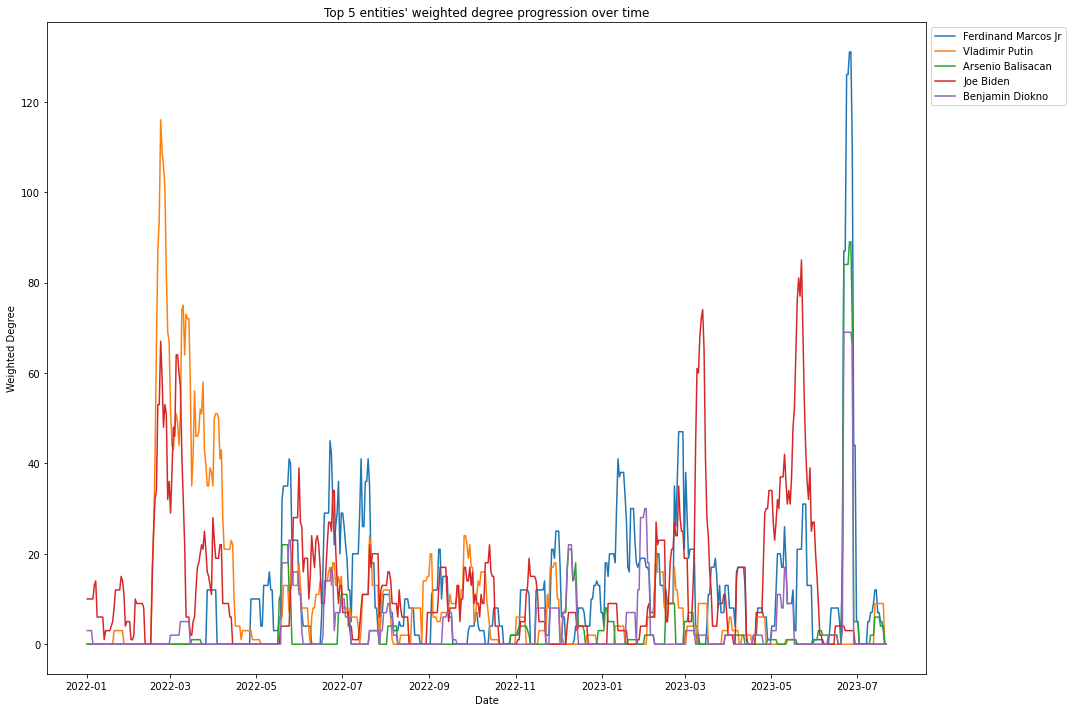

In [27]:
# Usage
weighted_rolling_window_analysis(df, 5)

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from datetime import timedelta
import imageio  # Needed to create GIFs

def weighted_rolling_window_analysis(df, p):
    df['date'] = pd.to_datetime(df['date'])
    
    start_date = df['date'].min()
    end_date = df['date'].max()
    current_date = start_date
    
    results = {}
    
    while current_date <= end_date:
        week_df = df[(df['date'] >= current_date) & (df['date'] < current_date + timedelta(7))]
        
        B = nx.Graph()
        B.add_nodes_from(week_df['id'], bipartite=0)
        entities = [entity for sublist in week_df['unique_entities'] for entity in eval(sublist)]
        B.add_nodes_from(set(entities), bipartite=1)
        for _, row in week_df.iterrows():
            for entity in eval(row['unique_entities']):
                B.add_edge(row['id'], entity)
        
        entity_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}
        entity_projection = nx.bipartite.weighted_projected_graph(B, entity_nodes)
        
        weighted_degree_dict = dict(entity_projection.degree(weight='weight'))
        for entity, degree in weighted_degree_dict.items():
            if entity not in results:
                results[entity] = []
            results[entity].append((current_date, degree))
        
        current_date += timedelta(1)

    all_dates = pd.date_range(start_date, end_date)
    for entity in results:
        existing_dates = {date for date, _ in results[entity]}
        missing_dates = set(all_dates) - existing_dates
        for missing_date in missing_dates:
            results[entity].append((missing_date, 0))
        results[entity].sort()

    max_degree_entities = sorted(results, key=lambda x: max([degree for _, degree in results[x]]), reverse=True)
    top_p_entities = max_degree_entities[:p]
    
    # Fetch default matplotlib colors
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_dict = {entity: color for entity, color in zip(top_p_entities, default_colors)}

    filenames = []
    for index, focus_entity in enumerate(top_p_entities):
        plt.figure(figsize=(18, 8))

        # Lists to store line handles and labels for creating the legend
        line_handles = []
        line_labels = []

        # Plot all non-focused entities and store their handles/labels
        for entity in top_p_entities:
            values = results[entity]
            dates, degrees = zip(*values)
            if entity != focus_entity:
                line, = plt.plot(dates, degrees, '-', color='lightgray', alpha=0.6)
                line_handles.append(line)
                line_labels.append(entity)

        # Plot the focused entity and store its handle/label
        values = results[focus_entity]
        dates, degrees = zip(*values)
        focused_line, = plt.plot(dates, degrees, '-', linewidth=2.5, color=color_dict[focus_entity])
        line_handles.append(focused_line)
        line_labels.append(focus_entity)

        plt.ylabel("Weighted Degree")
        plt.xlabel("Date")
        plt.title(f"Entity Projection Weighted Degree Progression Over Time")

        # Use the line_handles and line_labels lists to ensure the legend order is maintained
        plt.legend(handles=line_handles, labels=line_labels, loc='upper left', bbox_to_anchor=(0,1), ncol=1)

        plt.tight_layout()
        filename = f"{focus_entity}_plot.png"
        plt.savefig(filename, dpi=150)
        filenames.append(filename)
        plt.close()



    # Create GIF
    with imageio.get_writer('entity_progression.gif', mode='I', duration=1) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)


In [77]:
def weighted_rolling_window_analysis(df, p):
    df['date'] = pd.to_datetime(df['date'])
    
    start_date = df['date'].min()
    end_date = df['date'].max()
    current_date = start_date
    
    results = {}
    
    while current_date <= end_date:
        week_df = df[(df['date'] >= current_date) & (df['date'] < current_date + timedelta(7))]
        
        B = nx.Graph()
        B.add_nodes_from(week_df['id'], bipartite=0)
        entities = [entity for sublist in week_df['unique_entities'] for entity in eval(sublist)]
        B.add_nodes_from(set(entities), bipartite=1)
        for _, row in week_df.iterrows():
            for entity in eval(row['unique_entities']):
                B.add_edge(row['id'], entity)
        
        entity_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}
        entity_projection = nx.bipartite.weighted_projected_graph(B, entity_nodes)
        
        weighted_degree_dict = dict(entity_projection.degree(weight='weight'))
        for entity, degree in weighted_degree_dict.items():
            if entity not in results:
                results[entity] = []
            results[entity].append((current_date, degree))
        
        current_date += timedelta(1)

    all_dates = pd.date_range(start_date, end_date)
    for entity in results:
        existing_dates = {date for date, _ in results[entity]}
        missing_dates = set(all_dates) - existing_dates
        for missing_date in missing_dates:
            results[entity].append((missing_date, 0))
        results[entity].sort()

    max_degree_entities = sorted(results, key=lambda x: max([degree for _, degree in results[x]]), reverse=True)
    top_p_entities = max_degree_entities[:p]
    
    # Fetch default matplotlib colors
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_dict = {entity: color for entity, color in zip(top_p_entities, default_colors)}

    filenames = []
    for index, focus_entity in enumerate(top_p_entities):
        plt.figure(figsize=(18, 8))
        
        line_handles = []
        line_labels = []

        # Plot all entities in background, including the focused entity
        for entity in top_p_entities:
            values = results[entity]
            dates, degrees = zip(*values)
            if entity != focus_entity:
                line, = plt.plot(dates, degrees, '-', color='lightgray', alpha=0.6)
            else:
                line, = plt.plot(dates, degrees, '-', color=color_dict[entity], linewidth=2.5)
            line_handles.append(line)
            line_labels.append(entity)

        # Replot the focused entity to ensure it's in the foreground
        values = results[focus_entity]
        dates, degrees = zip(*values)
        plt.plot(dates, degrees, '-', linewidth=2.5, color=color_dict[focus_entity])

        plt.ylabel("Weighted Degree")
        plt.xlabel("Date")
        plt.legend(line_handles, line_labels, loc='upper left')
        plt.tight_layout()
        filename = f"{focus_entity}_plot.png"
        plt.savefig(filename, dpi=150)
        filenames.append(filename)
        plt.close()

    # Create GIF
    with imageio.get_writer('entity_progression.gif', mode='I', duration=1) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)


In [78]:
weighted_rolling_window_analysis(df, 5)  # Replace 'your_dataframe' with your actual DataFrame

# creating temporal plot

In [9]:
from tqdm import tqdm
import os
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors as mcolors

In [10]:
def get_window_graph(df, start_date):
    window_df = df[(df['date'] >= start_date) & (df['date'] < start_date + pd.Timedelta(days=7))]
    G = nx.Graph()
    for _, row in window_df.iterrows():
        article_id = row['id']
        entities = eval(row['unique_entities'])  # Converting the string list to a Python list
        for entity in entities:
            G.add_edge(article_id, entity)
    return G

def get_node_color(node, track_entities_colors):
    return mcolors.to_rgba(track_entities_colors.get(node, 'gray'), alpha=0.8 if node in track_entities_colors else 0.3)

def get_edge_color(edge, track_entities_colors, G):
    source, target = edge
    for node in [source, target]:
        if node in track_entities_colors:
            return mcolors.to_rgba(track_entities_colors[node], alpha=0.5)
    return (0.5, 0.5, 0.5, 0.2)

def average_positions(pos1, pos2, weight=0.75):
    """
    Average two sets of positions. Only nodes that exist in both sets are averaged.
    """
    avg_pos = {}
    for node in pos1:
        if node in pos2:
            x1, y1 = pos1[node]
            x2, y2 = pos2[node]
            avg_pos[node] = ((x1*(1-weight) + x2*weight), (y1*(1-weight) + y2*weight))
        else:
            avg_pos[node] = pos1[node]
    return avg_pos

# Assuming df is your DataFrame with columns 'date', 'id', and 'unique_entities'
# Initialize

track_entities_colors = {
    'Vladimir Putin': 'red',
    'Ferdinand Marcos Jr': 'blue',
    'Joe Biden': 'green'
}

start_date = df['date'].min()
end_date = df['date'].max() - pd.Timedelta(days=6)

frames_folder = "frames_folder"
if not os.path.exists(frames_folder):
    os.makedirs(frames_folder)

current_G = get_window_graph(df, start_date)
pos = nx.spring_layout(current_G, seed=42, k=0.9, iterations=200, scale=0.95)
sub_frames_count = 25

dates = [start_date + pd.Timedelta(days=i) for i in range((end_date - start_date).days + 1)]

for i in tqdm(range(len(dates) - 1)):
    current_date = dates[i]
    next_date = dates[i + 1]

    next_G = get_window_graph(df, next_date)
    pos_next_random = nx.spring_layout(next_G, seed=42, k=0.9, iterations=200, scale=0.95)
    pos_next = average_positions(pos_next_random, pos)

    for t in np.linspace(0, 1, sub_frames_count)[:-1]:
        intermediate_pos = {}
        for node in current_G.nodes():
            if node in pos and node in pos_next:
                x1, y1 = pos[node]
                x2, y2 = pos_next[node]
                intermediate_pos[node] = (x1 + t * (x2 - x1), y1 + t * (y2 - y1))
            elif node in pos:
                intermediate_pos[node] = pos[node]
        
        plt.figure(figsize=(8, 6))
        node_colors = [get_node_color(node, track_entities_colors) for node in current_G.nodes()]
        edge_colors = [get_edge_color(edge, track_entities_colors, current_G) for edge in current_G.edges()]

        nx.draw(current_G, intermediate_pos, with_labels=False, node_color=node_colors, edge_color=edge_colors, node_size=100)
        
        for entity, color in track_entities_colors.items():
            plt.plot(0, 0, color=mcolors.to_rgba(color, alpha=0.6), label=entity)
        plt.legend(loc="upper right")
        
        month_year = current_date.strftime('%B %Y')
        plt.suptitle(f"Entity Network around {month_year}", y=1.02)

        filename = os.path.join(frames_folder, f"frame_{current_date}_t{int(100*t)}.png")
        plt.savefig(filename, bbox_inches='tight', pad_inches=0.5, dpi=100)
        plt.close()

    current_G = next_G
    pos = pos_next

100%|███████████████████████████████████████| 560/560 [1:11:08<00:00,  7.62s/it]


In [14]:
def get_window_graph(df, start_date):
    window_df = df[(df['date'] >= start_date) & (df['date'] < start_date + pd.Timedelta(days=7))]
    G = nx.Graph()
    for _, row in window_df.iterrows():
        article_id = row['id']
        entities = eval(row['unique_entities'])  # Converting the string list to a Python list
        for entity in entities:
            G.add_edge(article_id, entity)
    return G

def get_node_color(node, track_entities_colors):
    return mcolors.to_rgba(track_entities_colors.get(node, 'gray'), alpha=0.8 if node in track_entities_colors else 0.3)

def get_edge_color(edge, track_entities_colors, G):
    source, target = edge
    for node in [source, target]:
        if node in track_entities_colors:
            return mcolors.to_rgba(track_entities_colors[node], alpha=0.5)
    return (0.5, 0.5, 0.5, 0.2)

def average_positions(pos1, pos2, weight=0.75):
    """
    Average two sets of positions. Only nodes that exist in both sets are averaged.
    """
    avg_pos = {}
    for node in pos1:
        if node in pos2:
            x1, y1 = pos1[node]
            x2, y2 = pos2[node]
            avg_pos[node] = ((x1*(1-weight) + x2*weight), (y1*(1-weight) + y2*weight))
        else:
            avg_pos[node] = pos1[node]
    return avg_pos

# Assuming df is your DataFrame with columns 'date', 'id', and 'unique_entities'
# Initialize

track_entities_colors = {
    'Vladimir Putin': 'red',
    'Ferdinand Marcos Jr': 'blue',
    'Joe Biden': 'green'
}

start_date = df['date'].min()
end_date = df['date'].max() - pd.Timedelta(days=6)

frames_folder = "frames_folder"
if not os.path.exists(frames_folder):
    os.makedirs(frames_folder)

current_G = get_window_graph(df, start_date)
pos = nx.spring_layout(current_G, seed=42, k=0.9, iterations=200, scale=0.95)
sub_frames_count = 10

dates = [start_date + pd.Timedelta(days=i) for i in range((end_date - start_date).days + 1)]

# Precompute the global xlim and ylim to keep the zoom level consistent across frames
all_positions = [pos]
all_x = []
all_y = []

for i in tqdm(range(len(dates) - 1)):
    next_date = dates[i + 1]
    next_G = get_window_graph(df, next_date)
    pos_next_random = nx.spring_layout(next_G, seed=42, k=0.9, iterations=200, scale=0.95)
    pos_next = average_positions(pos_next_random, pos)
    all_positions.append(pos_next)
    all_x.extend([coord[0] for coord in pos_next.values()])
    all_y.extend([coord[1] for coord in pos_next.values()])

margin = 0.05  # 5% margin

x_range = max(all_x) - min(all_x)
y_range = max(all_y) - min(all_y)

xlim = (min(all_x) - margin * x_range, max(all_x) + margin * x_range)
ylim = (min(all_y) - margin * y_range, max(all_y) + margin * y_range)

for i in tqdm(range(len(dates) - 1)):
    current_date = dates[i]
    next_date = dates[i + 1]

    next_G = get_window_graph(df, next_date)
    pos_next_random = nx.spring_layout(next_G, seed=42, k=0.9, iterations=200, scale=0.95)
    pos_next = average_positions(pos_next_random, pos)

    for t in np.linspace(0, 1, sub_frames_count)[:-1]:
        intermediate_pos = {}
        for node in current_G.nodes():
            if node in pos and node in pos_next:
                x1, y1 = pos[node]
                x2, y2 = pos_next[node]
                intermediate_pos[node] = (x1 + t * (x2 - x1), y1 + t * (y2 - y1))
            elif node in pos:
                intermediate_pos[node] = pos[node]
        
        plt.figure(figsize=(8, 6))
        node_colors = [get_node_color(node, track_entities_colors) for node in current_G.nodes()]
        edge_colors = [get_edge_color(edge, track_entities_colors, current_G) for edge in current_G.edges()]

        nx.draw(current_G, intermediate_pos, with_labels=False, node_color=node_colors, edge_color=edge_colors, node_size=100)
        plt.xlim(xlim)  # Fixing the x-axis limits
        plt.ylim(ylim)  # Fixing the y-axis limits

        for entity, color in track_entities_colors.items():
            plt.plot(0, 0, color=mcolors.to_rgba(color, alpha=0.6), label=entity)
        plt.legend(loc="upper right")
        
        month_year = current_date.strftime('%B %Y')
        plt.suptitle(f"Entity Network around {month_year}", y=1.02)

        filename = os.path.join(frames_folder, f"frame_{current_date}_t{int(100*t)}.png")
        plt.savefig(filename, bbox_inches='tight', pad_inches=0.5, dpi=80)
        plt.close()

    current_G = next_G
    pos = pos_next

100%|█████████████████████████████████████████| 560/560 [16:22<00:00,  1.75s/it]


In [9]:
start_date = df['date'].min()
end_date = df['date'].max() - pd.Timedelta(days=6)
dates = [start_date + pd.Timedelta(days=i) for i in range((end_date - start_date).days + 1)]
sub_frames_count = 15
frames_folder = "frames_folder"

In [10]:
fps = 30
frames = [imageio.imread(os.path.join(frames_folder, f"frame_{dates[i]}_t{int(100*t)}.png")) 
          for i in range(len(dates) - 1) for t in np.linspace(0, 1, sub_frames_count)[:-1]]
imageio.mimsave("animated_entity_network6.gif", frames, duration=1/fps)

In [16]:
fps = 120
frames = [imageio.imread(os.path.join(frames_folder, f"frame_{dates[i]}_t{int(100*t)}.png")) 
          for i in range(len(dates) - 1) for t in np.linspace(0, 1, sub_frames_count)[:-1]]
imageio.mimsave("animated_entity_network8.gif", frames, duration=1/fps)

In [44]:
from pygifsicle import optimize

optimize("animated_entity_network8.gif", "animated_entity_network9.gif")

gifsicle: warning: huge GIF, conserving memory (processing may take a while)
gifsicle: warning: trivial adaptive palette (only 256 colors in source)


In [2]:
from moviepy.editor import VideoFileClip

clip = VideoFileClip('animated_entity_network8.gif')
clip.write_gif('animated_entity_network10.gif', fps=5)  # Using reduced FPS too

MoviePy - Building file animated_entity_network10.gif with imageio.


In [36]:
dates = [start_date + pd.Timedelta(days=i) for i in range((end_date - start_date).days + 1)]
windows = [(date, get_window_graph(df, date)) for date in dates]

# Finding window with smallest and largest number of nodes
window_min_nodes = min(windows, key=lambda x: len(x[1].nodes()))
window_max_nodes = max(windows, key=lambda x: len(x[1].nodes()))

# Finding window with smallest and largest number of edges (links)
window_min_edges = min(windows, key=lambda x: len(x[1].edges()))
window_max_edges = max(windows, key=lambda x: len(x[1].edges()))


Analysis for Window starting at 2022-05-05 12:59:53:


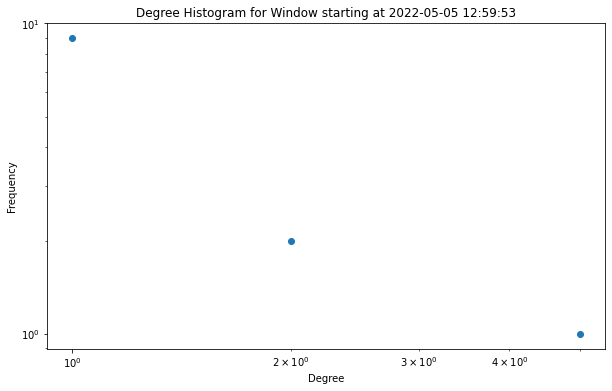

Average Clustering Coefficient: 0.0
The graph for Window starting at 2022-05-05 12:59:53 is not connected. Cannot compute average shortest path length.
Density: 0.13636363636363635
Average Degree Centrality: 0.13636363636363635
Average Closeness Centrality: 0.21380471380471378
Average Betweenness Centrality: 0.018181818181818184
Average Eigenvector Centrality: 0.19068944862260565
--------------------------------------------------
Analysis for Window starting at 2022-03-05 12:59:53:


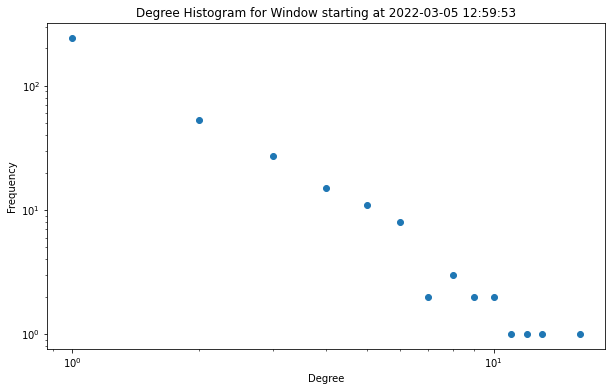

Average Clustering Coefficient: 0.0
The graph for Window starting at 2022-03-05 12:59:53 is not connected. Cannot compute average shortest path length.
Density: 0.0052597071464995995
Average Degree Centrality: 0.005259707146499579
Average Closeness Centrality: 0.04695988220413399
Average Betweenness Centrality: 0.0035152765019308943
Average Eigenvector Centrality: 0.020667030947511485
--------------------------------------------------
Analysis for Window starting at 2022-05-05 12:59:53:


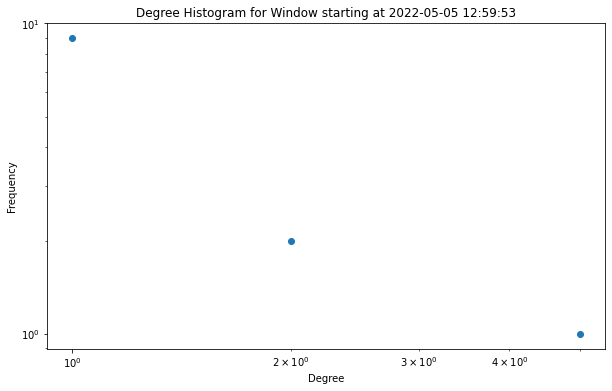

Average Clustering Coefficient: 0.0
The graph for Window starting at 2022-05-05 12:59:53 is not connected. Cannot compute average shortest path length.
Density: 0.13636363636363635
Average Degree Centrality: 0.13636363636363635
Average Closeness Centrality: 0.21380471380471378
Average Betweenness Centrality: 0.018181818181818184
Average Eigenvector Centrality: 0.19068944862260565
--------------------------------------------------
Analysis for Window starting at 2022-03-05 12:59:53:


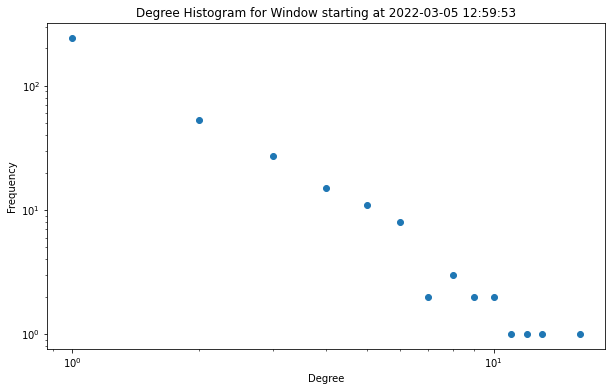

Average Clustering Coefficient: 0.0
The graph for Window starting at 2022-03-05 12:59:53 is not connected. Cannot compute average shortest path length.
Density: 0.0052597071464995995
Average Degree Centrality: 0.005259707146499579
Average Closeness Centrality: 0.04695988220413399
Average Betweenness Centrality: 0.0035152765019308943
Average Eigenvector Centrality: 0.020667030947511485
--------------------------------------------------


In [38]:
def perform_network_analysis(graph, graph_title):
    print(f"Analysis for {graph_title}:")

    # 1. Degree Distribution
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
    degree_count = collections.Counter(degree_sequence)
    deg, cnt = zip(*degree_count.items())

    plt.figure(figsize=(10, 6))
    plt.loglog(deg, cnt, 'o')
    plt.title("Degree Histogram for " + graph_title)
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # 2. Clustering Coefficient
    avg_clustering = nx.average_clustering(graph)
    print(f"Average Clustering Coefficient: {avg_clustering}")

    # 3. Average Shortest Path Length (this can be computationally intensive for large networks)
    # First, check if the graph is connected
    if nx.is_connected(graph):
        avg_path_length = nx.average_shortest_path_length(graph)
        print(f"Average Shortest Path Length: {avg_path_length}")
    else:
        print(f"The graph for {graph_title} is not connected. Cannot compute average shortest path length.")

    # 4. Density
    density = nx.density(graph)
    print(f"Density: {density}")

    # 5. Degree Centrality
    degree_centrality = nx.degree_centrality(graph)
    avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
    print(f"Average Degree Centrality: {avg_degree_centrality}")

    # 6.Closeness Centrality
    closeness_centrality = nx.closeness_centrality(graph)
    avg_closeness_centrality = sum(closeness_centrality.values()) / len(closeness_centrality)
    print(f"Average Closeness Centrality: {avg_closeness_centrality}")

    # 7. Betweenness Centrality
    betweenness_centrality = nx.betweenness_centrality(graph)
    avg_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)
    print(f"Average Betweenness Centrality: {avg_betweenness_centrality}")

    # 8. Eigenvector Centrality
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=1000)
    avg_eigenvector_centrality = sum(eigenvector_centrality.values()) / len(eigenvector_centrality)
    print(f"Average Eigenvector Centrality: {avg_eigenvector_centrality}")
    print("-" * 50)


# Call this function for each of the windows
windows_to_analyze = [window_min_nodes, window_max_nodes, window_min_edges, window_max_edges]
for window in windows_to_analyze:
    window_date, window_graph = window
    window_title = f"Window starting at {window_date}"
    perform_network_analysis(window_graph, window_title)
